# Project In Data Science 
## Stroke Prediction (EDA - ML experimentation)
### Author: Ioannis Stathakis

###

### Part 3: Model Training and Evaluation
#### In this part we will try to train an effective classifier for the target. Basic order of operations:
#### 1. Encode categorical variables (Label Encoding for binary, One-Hot Encoding for multiclass)
#### 2. Train/Test split of the data, for example 80/20 or 70/30.
#### 3. Applying SMOTE only after the train/test split, and only on the train data.
#### 4. Start training phase with a few baseline models, for example Logistic Regression and Naive Bayes.
#### 5. Maybe test more powerful models for comparison, and different sampling strategies.
#### 6. Hyper parameter tuning if needed, to improve performance of the best models.
### Finally, we will decide on the best model using standard metrics like ROC-AUC, Recall, F1-Score (Accuracy will not be suitable here due to the high imbalance we are facing).
### All modeling will be additionally separated into three different approaches, as far as the target imbalance is concerned:
#### 1. Oversampling with SMOTE to use 100% of the training set
#### 2. Oversampling with SMOTE but reducing the training set to for example 70%, so to fill the data with less synthetic values overall
#### 3. Downsampling to a positive/negative ratio of perhaps 40/60, to avoid synthetic values alltogether
#### 4. Using weighted approaches for each class, through the respective models in each trial

In [1]:
# Importing necessary libraries
import warnings
warnings.filterwarnings("ignore") # To ignore some reccuring system warnings of no importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold # This is to compensate for class imbalance in a later learning-curve visualization
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from pytorch_tabnet.tab_model import TabNetClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Lets import the prepared dataset and preprocess it to get it ready for the models
df = pd.read_csv("prepared_stroke_data.csv")
df.head()

,Age,Avg_Glucose_Level,Hypertension,Heart_Disease,BMI,Smoking_Status,Ever_Married,Stroke
0,67.0,228.69,No,Yes,36.6,formerly smoked,Yes,1
1,61.0,202.21,No,No,29.2,never smoked,Yes,1
2,80.0,105.92,No,Yes,32.5,never smoked,Yes,1
3,49.0,171.23,No,No,34.4,smokes,Yes,1
4,79.0,174.12,Yes,No,24.0,never smoked,Yes,1


###

## Preprocessing Phase

In [3]:
# Label Encoding for the binary variables (Yes/No to 1/0)
binary_map = {"Yes": 1, "No": 0}
df["Hypertension"] = df["Hypertension"].map(binary_map)
df["Heart_Disease"] = df["Heart_Disease"].map(binary_map)
df["Ever_Married"] = df["Ever_Married"].map(binary_map)

# One-Hot Encoding for Smoking_Status (drop first dummy column to avoid the Dummy Trap 
# The Dummy Trap is a perfect multicollinearity situation where one column can be perfectly predicted by the others
df = pd.get_dummies(df, columns=["Smoking_Status"], drop_first=True)

# Convert boolean dummies to binary integers
df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)

# Check our encoding results
df.head()

,Age,Avg_Glucose_Level,Hypertension,Heart_Disease,BMI,Ever_Married,Stroke,Smoking_Status_formerly smoked,Smoking_Status_never smoked,Smoking_Status_smokes
0,67.0,228.69,0,1,36.6,1,1,1,0,0
1,61.0,202.21,0,0,29.2,1,1,0,1,0
2,80.0,105.92,0,1,32.5,1,1,0,1,0
3,49.0,171.23,0,0,34.4,1,1,0,0,1
4,79.0,174.12,1,0,24.0,1,1,0,1,0


In [4]:
# Now lets proceed to the data split
# Separate features and target (Stroke column)
X = df.drop(columns=["Stroke"])
y = df["Stroke"]

# Split into training and testing sets (80/20 split)
# I will use stratification due to the high class imbalance of the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class balance in training set
print("Class distribution in y_train:\n", y_train.value_counts(normalize=True))

Class distribution in y_train:
 Stroke
0    0.951094
1    0.048906
Name: proportion, dtype: float64


###

## Modeling Phase
### Lets start with SMOTE oversampling to the 100% of the training data (Full SMOTE).

In [5]:
# Now that the split is done, lets apply SMOTE
# THis is only done on the train data, and never on the test data
# The reason for this is that we want the test data to be real examples, not probabilistic synthetic ones
# Initialize SMOTE algorithm
smote = SMOTE(random_state=42)

# Fit and resample training data (oversampling the minority class)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class balance after SMOTE
print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

Class distribution after SMOTE:
 Stroke
0    3870
1    3870
Name: count, dtype: int64


###

### Baseline models

In [6]:
# Now we can dive in the model training part
# Lets start with a couple of baseline models
# I will use Logistic Regression and Naive Bayes
# I do have to note though, that Naive Bayes might not be a fitting choice in our case
# This is because the model assumes independence of the features, but here this might not hold
# For example, "Hypertension" might not be independent to "Smoking_Status"
# However I will go ahead and experiment with the model, to see how it behaves

# Initialize models
log_reg = LogisticRegression(max_iter=1000, random_state=42)
nb = GaussianNB()

In [7]:
# Train the Logistic Regression model
log_reg.fit(X_train_smote, y_train_smote)


LogisticRegression(max_iter=1000, random_state=42)

In [8]:
# Use Test set for predictions
log_pred = log_reg.predict(X_test)

In [9]:
# Train the Naive Bayes model
nb.fit(X_train_smote, y_train_smote)


GaussianNB()

In [10]:
# Predictions
nb_pred = nb.predict(X_test)

In [11]:
# A quick function to keep track and visualize the metrics will be helpful

# Initialize dictionaries for each metric
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}

# A quick function to calculate specificity
def get_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Collect the metrics
def collect_metrics(name, y_true, y_pred, y_proba=None):
    metrics["Model"].append(name)
    metrics["Accuracy"].append((y_true == y_pred).mean())
    metrics["F1 Score"].append(f1_score(y_true, y_pred))
    metrics["Recall"].append(recall_score(y_true, y_pred))
    metrics["Specificity"].append(get_specificity(y_true, y_pred))
    metrics["Precision"].append(precision_score(y_true, y_pred))
    metrics["AUC"].append(roc_auc_score(y_true, y_proba if y_proba is not None else y_pred))


In [12]:
# Collect the metrics from the above models
collect_metrics("Logistic Regression", y_test, log_pred, log_reg.predict_proba(X_test)[:, 1])
collect_metrics("Naive Bayes", y_test, nb_pred, nb.predict_proba(X_test)[:, 1])

# Create results DataFrame
results_df = pd.DataFrame(metrics)

In [13]:
# Check out the results:
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Logistic Regression,0.808448,0.235294,0.6,0.819215,0.146341,0.773492
1,Naive Bayes,0.759332,0.169492,0.5,0.772727,0.102041,0.719504


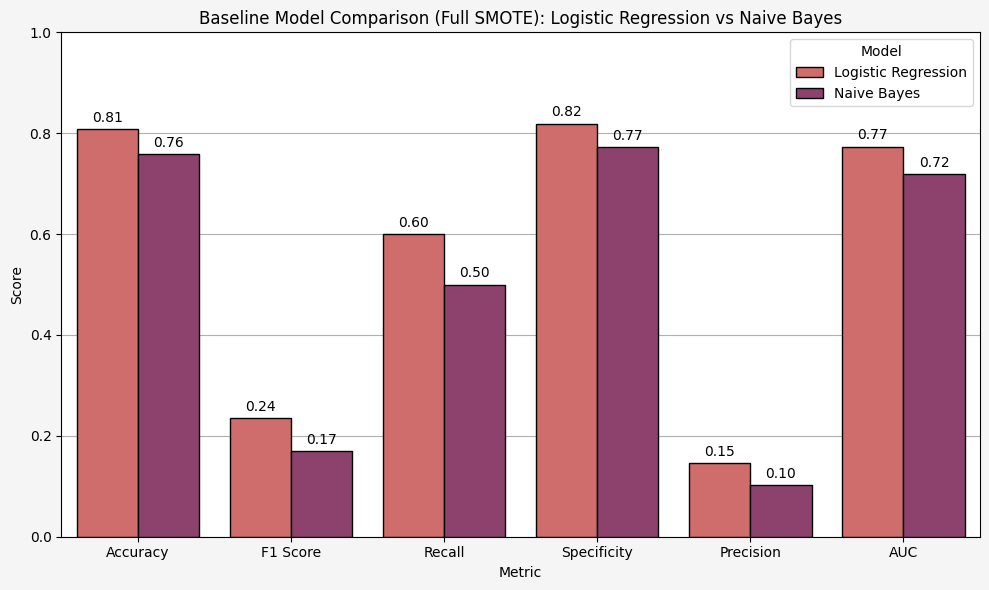

In [14]:
# Plot comparison
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Multiple Bar plot:
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="flare", edgecolor="black", zorder=2)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)
    
plt.title("Baseline Model Comparison (Full SMOTE): Logistic Regression vs Naive Bayes")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.tight_layout()
plt.show()


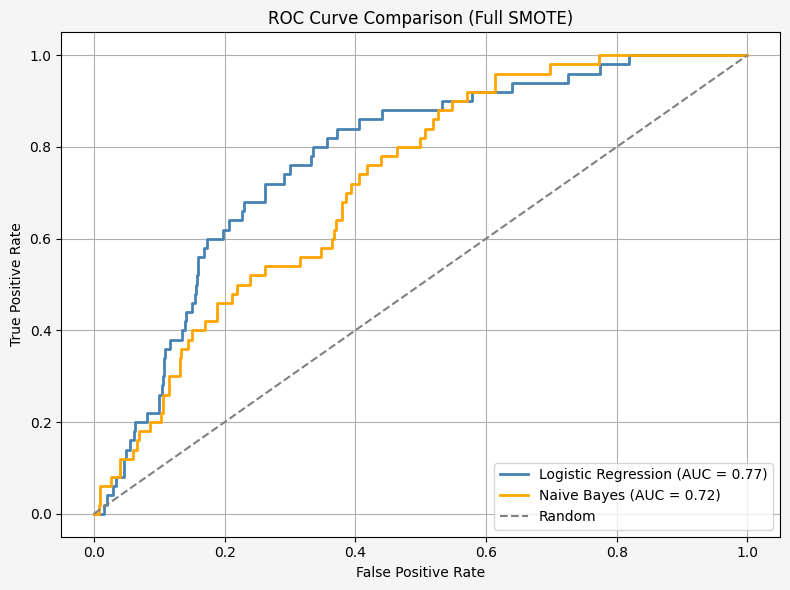

In [15]:
# Lets also plot the ROC-AUC for each of these models:
# Get probabilities
log_proba = log_reg.predict_proba(X_test)[:, 1]
nb_proba = nb.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUC
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_proba)

auc_log = auc(fpr_log, tpr_log)
auc_nb = auc(fpr_nb, tpr_nb)

# Plot ROC curves
plt.figure(figsize=(8, 6), facecolor="whitesmoke")
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})", linewidth=2, color="steelblue")
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_nb:.2f})", linewidth=2, color="orange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Full SMOTE)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Lets also do a parallel test for overfitting, just to rule this out
# Predict on training set (no SMOTE needed here because we use same training data the model saw)
log_train_pred = log_reg.predict(X_train_smote)
nb_train_pred = nb.predict(X_train_smote)

# Compute Recall during training and test phases
# We use Recall because, as already mentioned, Accuracy is not ideal in our situation
log_train_recall = recall_score(y_train_smote, log_train_pred)
log_test_recall = recall_score(y_test, log_pred)

nb_train_recall = recall_score(y_train_smote, nb_train_pred)
nb_test_recall = recall_score(y_test, nb_pred)


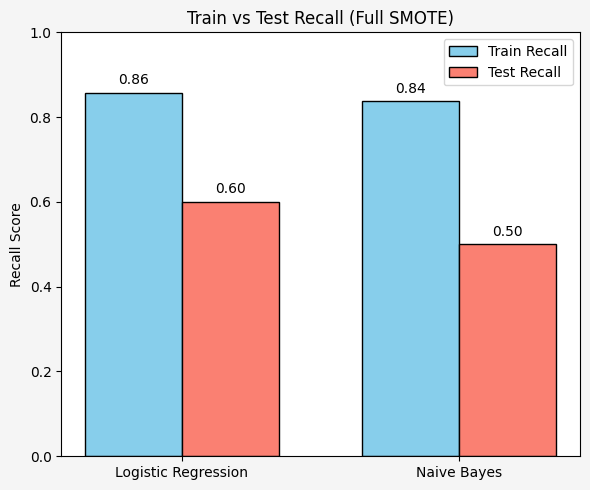

In [17]:
# Plot the Recall comparison
# Get the Recall values
plt.figure(figsize=(6, 5), facecolor="whitesmoke")
models = ["Logistic Regression", "Naive Bayes"]
train_recalls = [log_train_recall, nb_train_recall]
test_recalls = [log_test_recall, nb_test_recall]

bar_width = 0.35
x = range(len(models))

# Plot the bars
bars1 = plt.bar(x, train_recalls, width=bar_width, label="Train Recall", color="skyblue", edgecolor="black")
bars2 = plt.bar([p + bar_width for p in x], test_recalls, width=bar_width, label="Test Recall", color="salmon", edgecolor="black")

# Add annotations on top of each bar
# THis will make visual comparison easier and quicker!
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}", ha='center', fontsize=10, color='black')

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{height:.2f}", ha='center', fontsize=10, color='black')


plt.xticks([p + bar_width / 2 for p in x], models)
plt.ylabel("Recall Score")
plt.title("Train vs Test Recall (Full SMOTE)")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


###

#### Results are interesting but not very promising. The models also seem to be struggling a little bit, with the noise of the natural data in the test set, compared to the synthetic SMOTE-oversampled data in the training set. We can try changing the train/test split to 70/30, just to explore if it makes a difference. 
#### Lets try this with the Logistic Regression model:

In [18]:
# Split into training and testing sets (70/30 split)
# I will use stratification once again due to the high class imbalance of the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check class balance in training set
print("Class distribution in y_train:\n", y_train.value_counts(normalize=True))

Class distribution in y_train:
 Stroke
0    0.951124
1    0.048876
Name: proportion, dtype: float64


In [19]:
# Now that the split is done, lets apply SMOTE
smote = SMOTE(random_state=42)

# Fit and resample training data (oversampling the minority class)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class balance after SMOTE
print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

Class distribution after SMOTE:
 Stroke
0    3386
1    3386
Name: count, dtype: int64


In [20]:
# Initialize the Logoistic Regression Model again
log_reg = LogisticRegression(max_iter=1000, random_state=42)

In [21]:
# Train the model again
log_reg.fit(X_train_smote, y_train_smote)


LogisticRegression(max_iter=1000, random_state=42)

In [22]:
# Use Test set for predictions
log_pred = log_reg.predict(X_test)

In [23]:
# Define the metrics again
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}


# Collect the metrics again
collect_metrics("Logistic Regression", y_test, log_pred, log_reg.predict_proba(X_test)[:, 1])

# Create results DataFrame
results_df = pd.DataFrame(metrics)
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Logistic Regression,0.817944,0.219101,0.52,0.833333,0.13879,0.779669


###

#### It seems that the different train/test split percentages just made the performance slaightly worse.
#### Lets return to the original 80/20 split and continue from there.

In [24]:
# Split into training and testing sets (80/20 split)
# I will use stratification due to the high class imbalance of the target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class balance in training set
print("Class distribution in y_train:\n", y_train.value_counts(normalize=True))

Class distribution in y_train:
 Stroke
0    0.951094
1    0.048906
Name: proportion, dtype: float64


In [25]:
# Now that the split is done, lets apply SMOTE
# Initialize SMOTE algorithm
smote = SMOTE(random_state=42)

# Fit and resample training data (oversampling the minority class)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check class balance after SMOTE
print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

Class distribution after SMOTE:
 Stroke
0    3870
1    3870
Name: count, dtype: int64


###

### We can observe the following, so far:
#### 1. Both Models show high training Recall, and thats good! Probably means that they learned to recognize stroke cases well on the SMOTE-balanced data.
#### 2. Significant drop on test Recall, also for both models. Logistic Regression drops 26 points, and Naive Bayes drops 34 points in recall. This suggests overfitting to the synthetic data produced by the SMOTE algorithm. 

#### This is probably to be expected: 
#### - SMOTE creates synthetic, idealized minority examples, but test data contains real-world noise and imbalance.
#### - The model learns to pick up synthetic patterns that don’t always generalize.

#### 3. Specificity is generally quite acceptible for both these models.

###

### Conclusion:
#### Logistic Regression performs decently with moderate overfitting — still catches 60% of stroke cases, which isn't bad for baseline.

#### Naive Bayes has worse generalization, likely due to its independence assumption not holding with SMOTE-rebalanced features and probably also with the medical complex nature of the variables, which might not be statistically independent, to some extent.

###

### Lets try K-Nearest Neighbors (KNN) and Support Vector Machine (SVM) models and see how they perform under these same circumstances.

In [26]:
# KNN model training
knn = KNeighborsClassifier()
knn.fit(X_train_smote, y_train_smote)


KNeighborsClassifier()

In [27]:
# KNN model predictions
knn_pred = knn.predict(X_test)
knn_proba = knn.predict_proba(X_test)[:, 1]

In [28]:
# SVM model training (linear kernel)
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_linear.fit(X_train_smote, y_train_smote)  


SVC(kernel='linear', probability=True, random_state=42)

In [29]:
# SVM (linear kernel) predictions
svm_lin_pred = svm_linear.predict(X_test)
svm_lin_proba = svm_linear.predict_proba(X_test)[:, 1]

In [30]:
# SVM training (RBF kernel)
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)
svm_rbf.fit(X_train_smote, y_train_smote)


SVC(probability=True, random_state=42)

In [31]:
# SVM (RBF kernel) predictions
svm_rbf_pred = svm_rbf.predict(X_test)
svm_rbf_proba = svm_rbf.predict_proba(X_test)[:, 1]

In [32]:
# Initialize dictionaries for each metric
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}

# Collect the metrics from the above models
collect_metrics("K-Nearest Neighbors", y_test, knn_pred, knn_proba)
collect_metrics("SVM - Linear Kernel", y_test, svm_lin_pred, svm_lin_proba)
collect_metrics("SVM - RBF Kernel", y_test, svm_rbf_pred, svm_rbf_proba)

# Create results DataFrame
results_df = pd.DataFrame(metrics)

In [33]:
# Check out the results for all three models
results_df


,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,K-Nearest Neighbors,0.779961,0.205674,0.58,0.790289,0.125000,0.743037
1,SVM - Linear Kernel,0.797642,0.225564,0.60,0.807851,0.138889,0.766560
2,SVM - RBF Kernel,0.664047,0.197183,0.84,0.654959,0.111702,0.836054


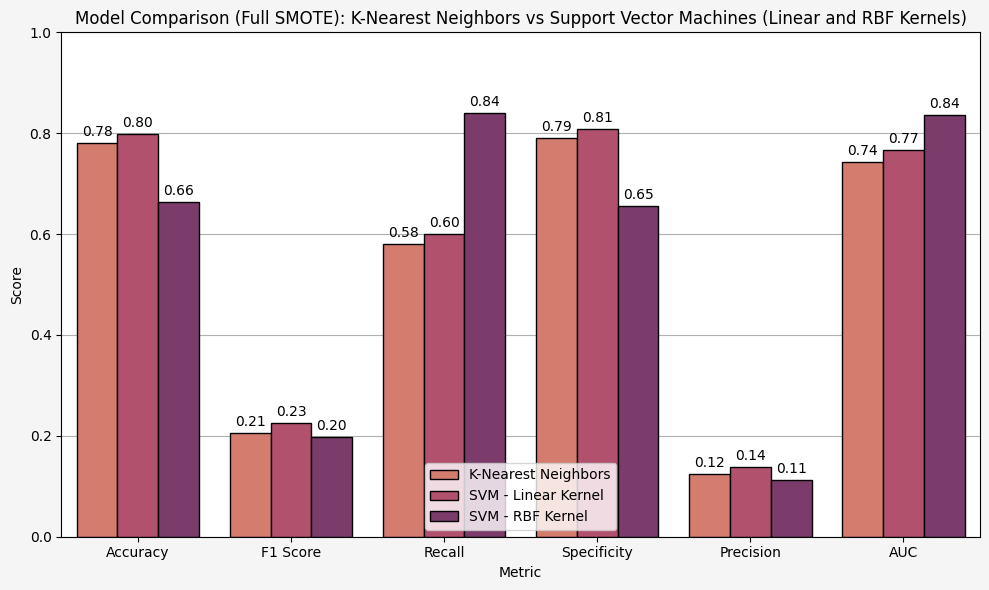

In [34]:
# Plot comparison
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Multiple Bar plot:
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="flare", edgecolor="black", zorder=2)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)
    
plt.title("Model Comparison (Full SMOTE): K-Nearest Neighbors vs Support Vector Machines (Linear and RBF Kernels)")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.legend(loc="lower center")
plt.tight_layout()
plt.show()

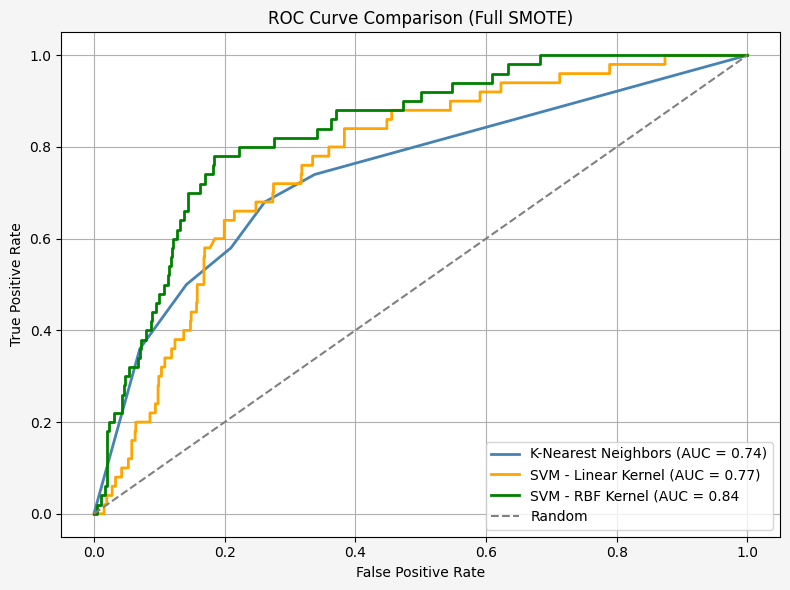

In [35]:
# Lets also generate ROC-AUC for these models
# Compute ROC curves and AUC
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_proba)
fpr_svm_lin, tpr_svm_lin, _ = roc_curve(y_test, svm_lin_proba)
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, svm_rbf_proba)

auc_knn = auc(fpr_knn, tpr_knn)
auc_svm_lin = auc(fpr_svm_lin, tpr_svm_lin)
auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

# Plot ROC curves
plt.figure(figsize=(8, 6), facecolor="whitesmoke")
plt.plot(fpr_knn, tpr_knn, label=f"K-Nearest Neighbors (AUC = {auc_knn:.2f})", linewidth=2, color="steelblue")
plt.plot(fpr_svm_lin, tpr_svm_lin, label=f"SVM - Linear Kernel (AUC = {auc_svm_lin:.2f})", linewidth=2, color="orange")
plt.plot(fpr_svm_rbf, tpr_svm_rbf, label=f"SVM - RBF Kernel (AUC = {auc_svm_rbf:.2f}", linewidth=2, color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Full SMOTE)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

###

#### The SVM model, especially with the RBF kernel, seems promising: Sensitivity, Specificity and AUC quite satisfactory, some higher than the Logistic Regression model, some lower. Definitely worth to keep both in mind as a potential candidates as the testing continues.


#### Lets try a few more flexible and robust models!
#### I will train and evaluate a Random Forest and an XGBoost model next.

In [36]:
# Train both models
# Random Forest:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_smote, y_train_smote)



RandomForestClassifier(random_state=42)

In [37]:
# XGBoost:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [38]:
# Predictions for both:
rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)


In [39]:
# Get the Probabilities
rf_proba = rf.predict_proba(X_test)[:, 1]
xgb_proba = xgb.predict_proba(X_test)[:, 1]


In [40]:
# Initialize dictionaries for each metric once again
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}

# Collect the metrics from the Random Forest and XGBoost models
collect_metrics("Random Forest", y_test, rf_pred, rf_proba)
collect_metrics("XGBoost", y_test, xgb_pred, xgb_proba)

# Create results DataFrame
results_df = pd.DataFrame(metrics)

In [41]:
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Random Forest,0.885069,0.170213,0.24,0.918388,0.131868,0.785661
1,XGBoost,0.894892,0.195489,0.26,0.927686,0.156627,0.740124


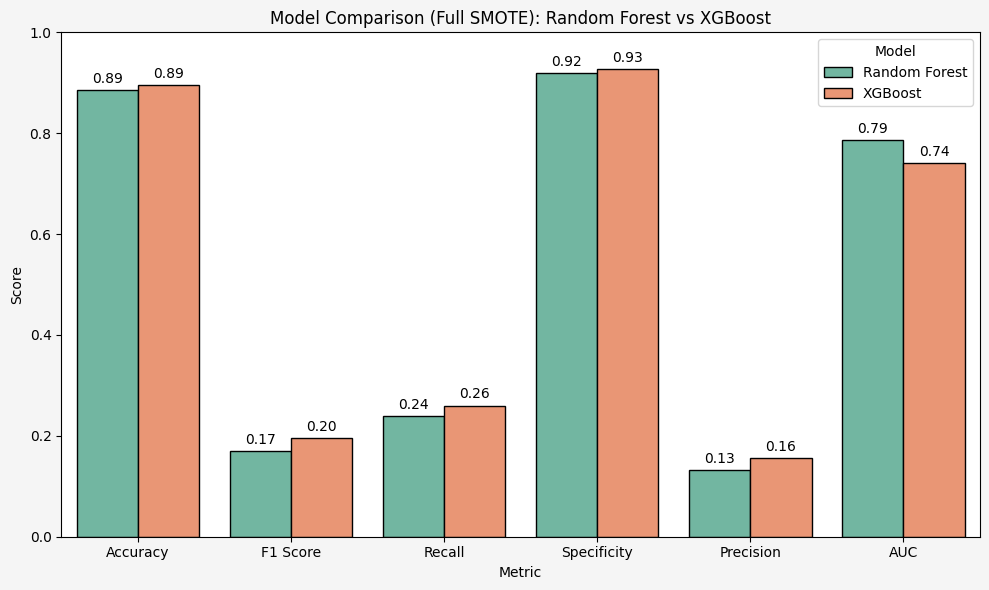

In [42]:
# We can observe very low Recall for these models
# Barplot of metrics
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Define the barplot
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="Set2", edgecolor="black")

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)

plt.title("Model Comparison (Full SMOTE): Random Forest vs XGBoost")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

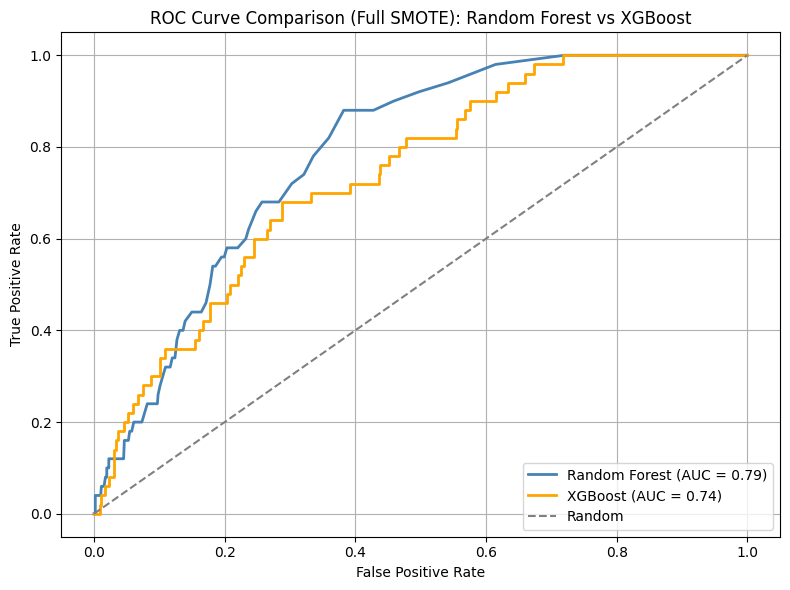

In [43]:
# Lets plot the ROC-AUC curves once again!
# Get ROC curve values
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)

# Compute AUC
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", linewidth=2, color="steelblue")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})", linewidth=2, color="orange")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random")

# Style
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Full SMOTE): Random Forest vs XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

###

### Some Key Observations:
#### 1. Accuracy is obviously missleadingly high - Both RF and XGBoost have accuracy > 88%, but that’s just because the dataset is highly imbalanced — most predictions are probably just "No Stroke."
#### 2. Recall dropped for both models. Logistic Regression earlier gave Recall = 0.60, which was much higher than the 0.24–0.26 we are getting now. That’s a big deal, because recall is critical for stroke prediction (catching actual positives).
#### 3. AUC also decreased. AUC went from around 0.84 in Logistic Regression to 0.79 (Random Foresst) and 0.74 (XGBoost). This indicates a weaker ability to separate positive from negative cases.
#### 4. Precision stayed low. We might have expected a trade-off between recall and precision, but here, both are low, so no real gain with these models.
#### 5. Specificity is extremely high but that is of little worth, when taking into account the extremely low sensitivity.

###

### Where are we so far:

#### We have already:

#### 1. Tested a nice variety of models across multiple families (linear, tree-based, probabilistic, distance-based).

#### 2. Measured six different metrics, including the clinically relevant recall and specificity which is our focus on this occasion.

#### 3. Found that Logistic Regression and SVMs consistently balance recall, AUC, and interpretability.

#### 4. Identified models that clearly underperform (Random Forest, XGBoost, Naive Bayes), and in my opinion aren’t worth further tuning or SMOTE variations.

###

#### I am going to continue with keeping just Logistic Regression, SVM (linear kernel) and SVM (RBF kernel), from here on.

#### I consider this decision to be scientifically justified and logistically efficient at this point, as well as intellectually honest. There doesn't seem to be any value in throwing more compute at Random Forest or XGBoost when they have shown such weak recall, especially for a clinical task like stroke prediction where recall is probably our number one concern.

####

### Lets continue with the reduced SMOTE oversampling plan, for example using a positive/negative ratio of 40/60.
### This will allow us to use less synthetic data in our training set, which might cause the models to generalize better.

In [44]:
# Lets start by counting the positives and negatives of the target, in the training set
from collections import Counter

# Count original class distribution
print("Original training set:", Counter(y_train))


Original training set: Counter({0: 3870, 1: 199})


In [45]:
# Target reduced oversampling ratio (for example, a positive/negative ratio of 40/60)
neg_count = sum(y_train == 0)
pos_target = int((2/3) * neg_count)
sampling_strategy = pos_target / neg_count

# Apply reduced SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_smote_red, y_train_smote_red = smote.fit_resample(X_train, y_train)

# Check new balance
print("New class distribution:", Counter(y_train_smote_red))

New class distribution: Counter({0: 3870, 1: 2580})


###

### Lets train our candidates again and see how they perform in this approach:

In [46]:
# Initialize the three models again
# Then we will train each model using the reduced SMOTE-oversampled training set
log_reg = LogisticRegression(max_iter=1000, random_state=42)
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)


In [47]:
# Train the Logistic Regression model
log_reg.fit(X_train_smote_red, y_train_smote_red)

LogisticRegression(max_iter=1000, random_state=42)

In [48]:
# SVM model training (linear kernel)
svm_linear.fit(X_train_smote_red, y_train_smote_red) 

SVC(kernel='linear', probability=True, random_state=42)

In [49]:
# SVM training (RBF kernel)
svm_rbf.fit(X_train_smote_red, y_train_smote_red)

SVC(probability=True, random_state=42)

In [50]:
# Use Test set for predictions and get the probabilities

# Logistic Regression
log_pred = log_reg.predict(X_test)
log_proba = log_reg.predict_proba(X_test)[:, 1]

# SVM (linear kernel) 
svm_lin_pred = svm_linear.predict(X_test)
svm_lin_proba = svm_linear.predict_proba(X_test)[:, 1]

# SVM (RBF kernel) predictions
svm_rbf_pred = svm_rbf.predict(X_test)
svm_rbf_proba = svm_rbf.predict_proba(X_test)[:, 1]

In [51]:
# Initialize dictionaries for each metric
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}

# Collect the metrics from the above models
collect_metrics("Logistic Regression", y_test, log_pred, log_proba)
collect_metrics("SVM - Linear Kernel", y_test, svm_lin_pred, svm_lin_proba)
collect_metrics("SVM - RBF Kernel", y_test, svm_rbf_pred, svm_rbf_proba)

# Create results DataFrame
results_df = pd.DataFrame(metrics)

In [52]:
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Logistic Regression,0.833988,0.206573,0.44,0.854339,0.134969,0.774731
1,SVM - Linear Kernel,0.837917,0.187192,0.38,0.861570,0.124183,0.752727
2,SVM - RBF Kernel,0.746562,0.236686,0.80,0.743802,0.138889,0.839917


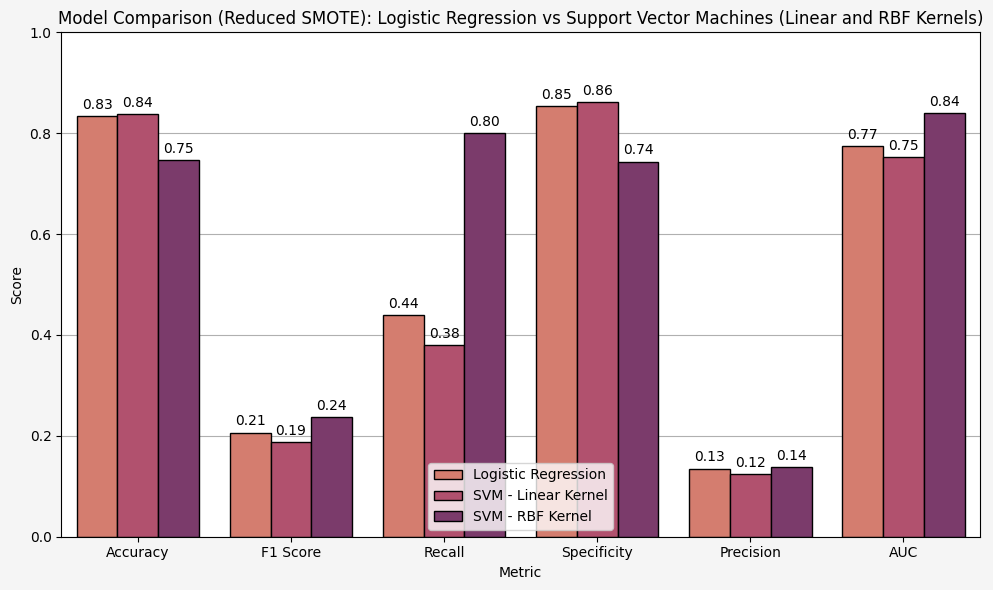

In [53]:
# Plot comparison
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Multiple Bar plot:
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="flare", edgecolor="black", zorder=2)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)
    
plt.title("Model Comparison (Reduced SMOTE): Logistic Regression vs Support Vector Machines (Linear and RBF Kernels)")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.legend(loc="lower center")
plt.tight_layout()
plt.show()

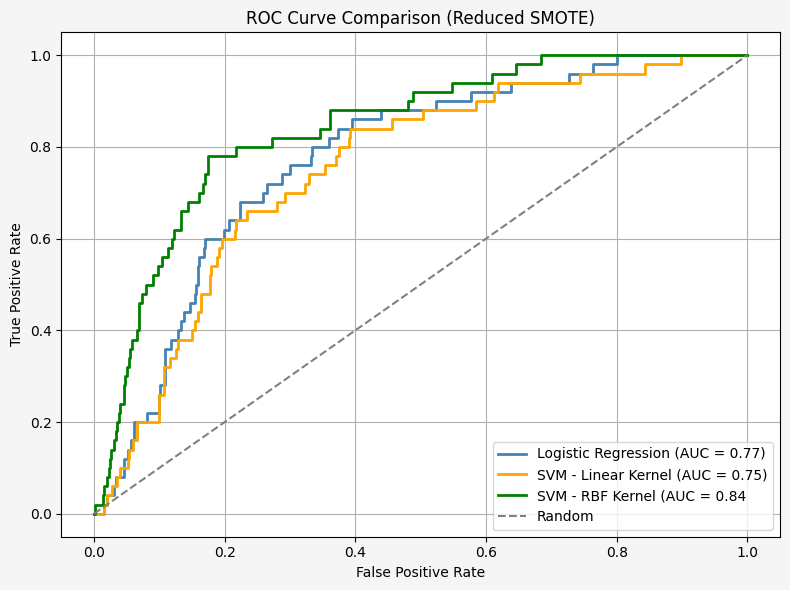

In [54]:
# Lets plot ROC-AUC curves for these models as well
# Compute ROC curves and AUC
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
fpr_svm_lin, tpr_svm_lin, _ = roc_curve(y_test, svm_lin_proba)
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, svm_rbf_proba)

auc_log = auc(fpr_log, tpr_log)
auc_svm_lin = auc(fpr_svm_lin, tpr_svm_lin)
auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

# Plot ROC curves
plt.figure(figsize=(8, 6), facecolor="whitesmoke")
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})", linewidth=2, color="steelblue")
plt.plot(fpr_svm_lin, tpr_svm_lin, label=f"SVM - Linear Kernel (AUC = {auc_svm_lin:.2f})", linewidth=2, color="orange")
plt.plot(fpr_svm_rbf, tpr_svm_rbf, label=f"SVM - RBF Kernel (AUC = {auc_svm_rbf:.2f}", linewidth=2, color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Reduced SMOTE)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
# Lets also test for overfitting, by examining the train/test Recall for these models, like earlier
# Track the training/testing phase metric:

# Logistic Regression model
log_train_pred = log_reg.predict(X_train_smote_red)
log_test_pred = log_reg.predict(X_test)
log_train_recall = recall_score(y_train_smote_red, log_train_pred)
log_test_recall = recall_score(y_test, log_test_pred)

# SVM (Linear Kernel) model
svm_lin_train_pred = svm_linear.predict(X_train_smote_red)
svm_lin_test_pred = svm_linear.predict(X_test)
svm_lin_train_recall = recall_score(y_train_smote_red, svm_lin_train_pred)
svm_lin_test_recall = recall_score(y_test, svm_lin_test_pred)

# SVM (RBF Kernel) model
svm_rbf_train_pred = svm_rbf.predict(X_train_smote_red)
svm_rbf_test_pred = svm_rbf.predict(X_test)
svm_rbf_train_recall = recall_score(y_train_smote_red, svm_rbf_train_pred)
svm_rbf_test_recall = recall_score(y_test, svm_rbf_test_pred)

# Check them all out:
print(f"LogReg - Train Recall: {log_train_recall:.2f} | Test Recall: {log_test_recall:.2f}")
print(f"SVM Linear - Train Recall: {svm_lin_train_recall:.2f} | Test Recall: {svm_lin_test_recall:.2f}")
print(f"SVM RBF - Train Recall: {svm_rbf_train_recall:.2f} | Test Recall: {svm_rbf_test_recall:.2f}")


LogReg - Train Recall: 0.78 | Test Recall: 0.44
SVM Linear - Train Recall: 0.80 | Test Recall: 0.38
SVM RBF - Train Recall: 0.73 | Test Recall: 0.80


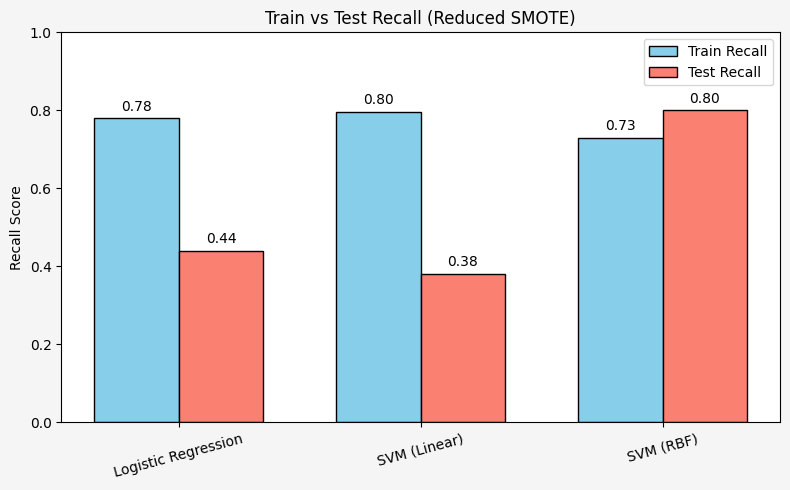

In [56]:
# Lets plot everything so we can examine the metrics more easily and consicely
models = ["Logistic Regression", "SVM (Linear)", "SVM (RBF)"]
train_recalls = [log_train_recall, svm_lin_train_recall, svm_rbf_train_recall]
test_recalls = [log_test_recall, svm_lin_test_recall, svm_rbf_test_recall]

# Bar plot setup
bar_width = 0.35
x = range(len(models))

plt.figure(figsize=(8, 5), facecolor="whitesmoke")
plt.bar(x, train_recalls, width=bar_width, label="Train Recall", color="skyblue", edgecolor="black")
plt.bar([p + bar_width for p in x], test_recalls, width=bar_width, label="Test Recall", color="salmon", edgecolor="black")

# Label setup
plt.xticks([p + bar_width / 2 for p in x], models, rotation=15)
plt.ylabel("Recall Score")
plt.ylim(0, 1)
plt.title("Train vs Test Recall (Reduced SMOTE)")
plt.legend()

# Annotate bars with values
for i, (train, test) in enumerate(zip(train_recalls, test_recalls)):
    plt.text(i, train + 0.02, f"{train:.2f}", ha='center')
    plt.text(i + bar_width, test + 0.02, f"{test:.2f}", ha='center')

plt.tight_layout()
plt.show()

###

### Lets summarize our results so far in a couple of tables:

#### Model Performance Summary: Full SMOTE vs Reduced SMOTE

#### Performance Metrics (Test Set):
|Model|SMOTE Strategy	|Accuracy	|F1 Score	|Recall	|Specificity	|Precision	|AUC|
|:----|:----------------|:----------|:----------|:------|:--------------|:----------|:--|
|Logistic Regression	|Full SMOTE|	0.808448|	0.235294|	0.600000|	0.819215|	0.146341|	0.773492|
|Logistic Regression	|Reduced SMOTE)|	0.833988|	0.206573|	0.440000|	0.854339|	0.134969|	0.774731|
|SVM - Linear Kernel	|Full SMOTE|	0.797642|	0.225564|	0.600000|	0.807851|	0.138889|	0.766560|
|SVM - Linear Kernel	|Reduced SMOTE)|	0.837917|	0.187192|	0.380000|	0.861570|	0.124183|	0.752727|
|SVM - RBF Kernel	|Full SMOTE|	0.664047|	0.197183|	0.840000|	0.654959|	0.111702|	0.836054|
|SVM - RBF Kernel	|Reduced SMOTE|	0.746562|	0.236686|	0.800000|	0.743802|	0.138889|	0.839917|


#### Overfitting Check (Train vs Test Recall, Reduced SMOTE):

|Model	|Train Recall|	Test Recall|
|:------|:-----------|:------------|
|Logistic Regression|	0.78|	0.44|
|SVM - Linear Kernel|	0.80|	0.38|
|SVM - RBF Kernel|	0.73|	0.80|


 #### So up until this point, three classifiers (Logistic Regression, SVM with linear kernel, and SVM with RBF kernel) were trained and evaluated using both full SMOTE (50/50 class balance) and reduced SMOTE (approximately 40/60 balance) oversampling strategies. Results showed that both Logistic Regression and SVM (linear) performed better under full SMOTE, with higher recall (0.60 vs 0.44 and 0.38 respectively), while maintaining strong specificity and balanced AUC values. On the other hand, SVM (RBF) maintained consistently high recall across both strategies (0.84 and 0.80), with strong AUC (above 0.83) and improved precision under reduced SMOTE.

#### Overfitting checks revealed significant gaps between train and test recall for the linear models, suggesting some degree of overfitting with reduced SMOTE. However, SVM with RBF kernel demonstrated strong generalization, with train and test recall values closely aligned (0.73 vs 0.80). These findings suggest that while full SMOTE is beneficial for linear models, SVM (RBF) is currently the most robust performer across both synthetic oversampling strategies.

###

### Lets continue to the next phase: Downsampling the original dataset to avoid synthetic data addition altogether.

In [57]:
# Now we will reduce the majority target class (negatives) to create a roughly 60/40 ratio of negatives/positives
# We will not generate any synthetic data using SMOTE, just use the real samples from the original dataset
# The goal is therefore to have a final target class balance of about 60% negatives, and 40% positives
# To do this, we will randomly downsample the majority class, to match the desired ratio
# The benefit is that we will avoid the caveats which go along the use of synthetic data 
# (strong overfitting models which struggle with the real data in the test set)
from sklearn.utils import resample

# Combine X_train and y_train for easy manipulation
train_df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_df = train_df[train_df["Stroke"] == 0]
minority_df = train_df[train_df["Stroke"] == 1]

# The desired ratio is 60/40 
# Lets calculate target majority count
target_majority_size = int((len(minority_df) / 0.4) * 0.6)
target_majority_size

298

In [58]:
# Downsample the majority class
downsampled_majority = resample(majority_df,
                                replace=False,
                                n_samples=target_majority_size,
                                random_state=42)

# Combine to create re-balanced dataset
downsampled_df = pd.concat([downsampled_majority, minority_df])

# Shuffle the rows
downsampled_df = downsampled_df.sample(frac=1, random_state=42)

# Split X and y
X_train_down = downsampled_df.drop(columns=["Stroke"])
y_train_down = downsampled_df["Stroke"]


In [59]:
#  A final sanity check
print("Downsampled class distribution:")
print(y_train_down.value_counts(normalize=True))

Downsampled class distribution:
Stroke
0    0.599598
1    0.400402
Name: proportion, dtype: float64


###

#### Downsampling is finished, lets dive into some training!

In [60]:
# Initialize the three models again
# Then we will train each model using the reduced SMOTE-oversampled training set
log_reg = LogisticRegression(max_iter=1000, random_state=42)
svm_linear = SVC(kernel='linear', probability=True, random_state=42)
svm_rbf = SVC(kernel='rbf', probability=True, random_state=42)


In [61]:
# Train the Logistic Regression model
log_reg.fit(X_train_down, y_train_down)

LogisticRegression(max_iter=1000, random_state=42)

In [62]:
# SVM model training (linear kernel)
svm_linear.fit(X_train_down, y_train_down) 

SVC(kernel='linear', probability=True, random_state=42)

In [63]:
# SVM training (RBF kernel)
svm_rbf.fit(X_train_down, y_train_down)

SVC(probability=True, random_state=42)

In [64]:
# Use Test set for predictions and get the probabilities

# Logistic Regression
log_pred = log_reg.predict(X_test)
log_proba = log_reg.predict_proba(X_test)[:, 1]

# SVM (linear kernel) 
svm_lin_pred = svm_linear.predict(X_test)
svm_lin_proba = svm_linear.predict_proba(X_test)[:, 1]

# SVM (RBF kernel) predictions
svm_rbf_pred = svm_rbf.predict(X_test)
svm_rbf_proba = svm_rbf.predict_proba(X_test)[:, 1]

In [65]:
# Initialize dictionaries for each metric
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}

# Collect the metrics from the above models
collect_metrics("Logistic Regression", y_test, log_pred, log_proba)
collect_metrics("SVM - Linear Kernel", y_test, svm_lin_pred, svm_lin_proba)
collect_metrics("SVM - RBF Kernel", y_test, svm_rbf_pred, svm_rbf_proba)

# Create results DataFrame
results_df = pd.DataFrame(metrics)

In [66]:
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Logistic Regression,0.779961,0.258278,0.78,0.779959,0.154762,0.838574
1,SVM - Linear Kernel,0.757367,0.253776,0.84,0.753099,0.149466,0.838161
2,SVM - RBF Kernel,0.723969,0.225895,0.82,0.719008,0.130990,0.839711


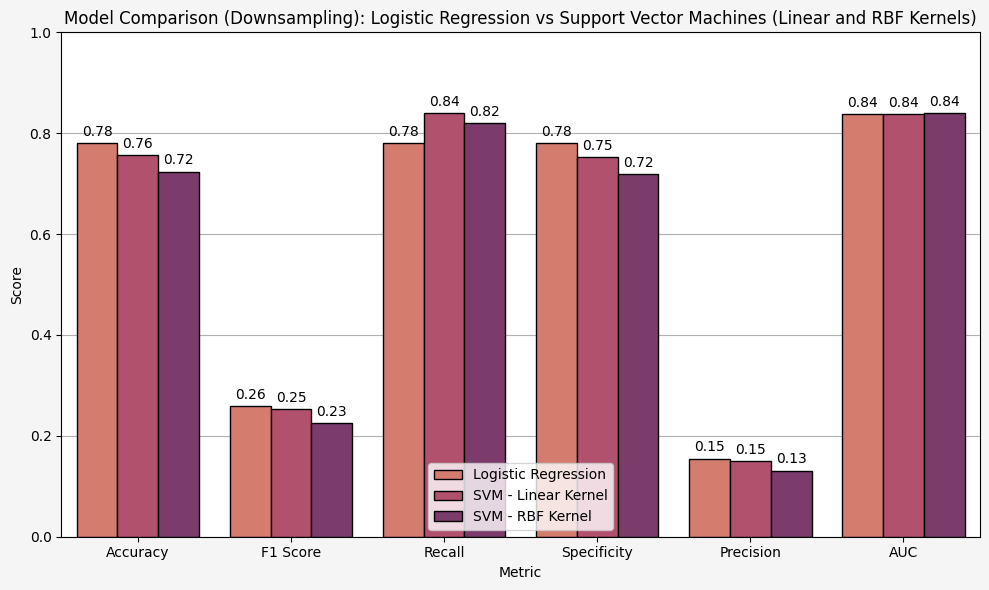

In [67]:
# Plot comparison
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Multiple Bar plot:
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="flare", edgecolor="black", zorder=2)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)
    
plt.title("Model Comparison (Downsampling): Logistic Regression vs Support Vector Machines (Linear and RBF Kernels)")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.legend(loc="lower center")
plt.tight_layout()
plt.show()

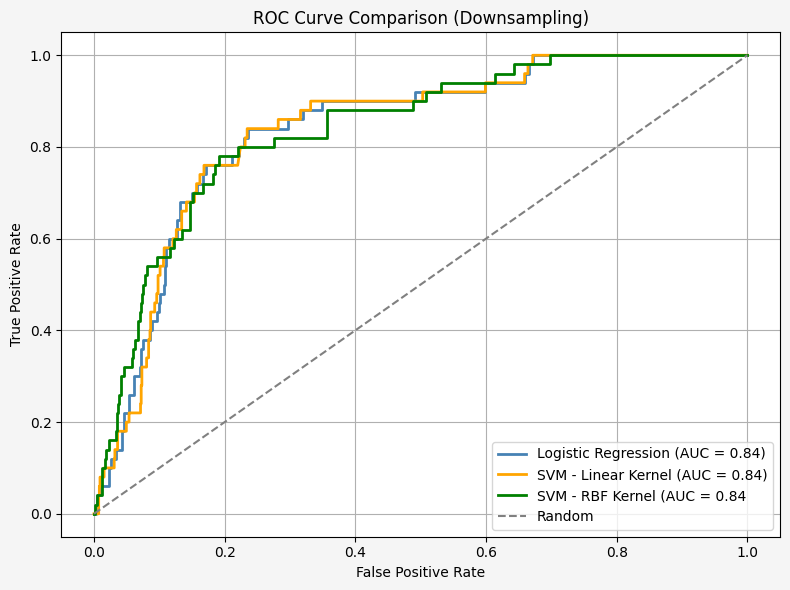

In [68]:
# Lets plot ROC-AUC curves for these models as well
# Compute ROC curves and AUC
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
fpr_svm_lin, tpr_svm_lin, _ = roc_curve(y_test, svm_lin_proba)
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, svm_rbf_proba)

auc_log = auc(fpr_log, tpr_log)
auc_svm_lin = auc(fpr_svm_lin, tpr_svm_lin)
auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

# Plot ROC curves
plt.figure(figsize=(8, 6), facecolor="whitesmoke")
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})", linewidth=2, color="steelblue")
plt.plot(fpr_svm_lin, tpr_svm_lin, label=f"SVM - Linear Kernel (AUC = {auc_svm_lin:.2f})", linewidth=2, color="orange")
plt.plot(fpr_svm_rbf, tpr_svm_rbf, label=f"SVM - RBF Kernel (AUC = {auc_svm_rbf:.2f}", linewidth=2, color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Downsampling)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
# Lets also test for overfitting, by examining the train/test Recall for these models, like earlier
# Track the training/testing phase metric:

# Logistic Regression model
log_train_pred = log_reg.predict(X_train_down)
log_test_pred = log_reg.predict(X_test)
log_train_recall = recall_score(y_train_down, log_train_pred)
log_test_recall = recall_score(y_test, log_test_pred)

# SVM (Linear Kernel) model
svm_lin_train_pred = svm_linear.predict(X_train_down)
svm_lin_test_pred = svm_linear.predict(X_test)
svm_lin_train_recall = recall_score(y_train_down, svm_lin_train_pred)
svm_lin_test_recall = recall_score(y_test, svm_lin_test_pred)

# SVM (RBF Kernel) model
svm_rbf_train_pred = svm_rbf.predict(X_train_down)
svm_rbf_test_pred = svm_rbf.predict(X_test)
svm_rbf_train_recall = recall_score(y_train_down, svm_rbf_train_pred)
svm_rbf_test_recall = recall_score(y_test, svm_rbf_test_pred)

# Check them all out:
print(f"LogReg - Train Recall: {log_train_recall:.2f} | Test Recall: {log_test_recall:.2f}")
print(f"SVM Linear - Train Recall: {svm_lin_train_recall:.2f} | Test Recall: {svm_lin_test_recall:.2f}")
print(f"SVM RBF - Train Recall: {svm_rbf_train_recall:.2f} | Test Recall: {svm_rbf_test_recall:.2f}")

LogReg - Train Recall: 0.69 | Test Recall: 0.78
SVM Linear - Train Recall: 0.74 | Test Recall: 0.84
SVM RBF - Train Recall: 0.75 | Test Recall: 0.82


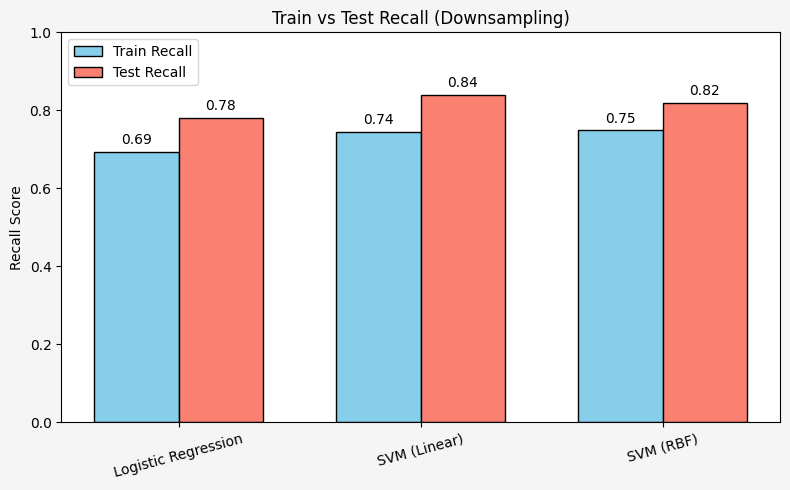

In [70]:
# Lets plot everything so we can examine the metrics more easily and consicely
models = ["Logistic Regression", "SVM (Linear)", "SVM (RBF)"]
train_recalls = [log_train_recall, svm_lin_train_recall, svm_rbf_train_recall]
test_recalls = [log_test_recall, svm_lin_test_recall, svm_rbf_test_recall]

# Bar plot setup
bar_width = 0.35
x = range(len(models))

plt.figure(figsize=(8, 5), facecolor="whitesmoke")
plt.bar(x, train_recalls, width=bar_width, label="Train Recall", color="skyblue", edgecolor="black")
plt.bar([p + bar_width for p in x], test_recalls, width=bar_width, label="Test Recall", color="salmon", edgecolor="black")

# Label setup
plt.xticks([p + bar_width / 2 for p in x], models, rotation=15)
plt.ylabel("Recall Score")
plt.ylim(0, 1)
plt.title("Train vs Test Recall (Downsampling)")
plt.legend()

# Annotate bars with values
for i, (train, test) in enumerate(zip(train_recalls, test_recalls)):
    plt.text(i, train + 0.02, f"{train:.2f}", ha='center')
    plt.text(i + bar_width, test + 0.02, f"{test:.2f}", ha='center')

plt.tight_layout()
plt.show()

###

#### Thoughts so far:

|Model	|Best Recall|	Best AUC|	Most Balanced|
|:------|:----------|:----------|:---------------|
|LogReg	|Downsampling (0.78)	|Downsampling (0.84)	|Downsampling overall|
|SVM Linear	|Downsampling (0.84)	|Downsampling (0.84)	|Very promising|
|SVM RBF	|Full SMOTE (0.84) / Down (0.82)	|Reduced SMOTE (0.84)	|Extremely robust across all|


#### All three models benefit from downsampling, with solid recall and high AUC. The SVM (RBF Kernel) remains most consistent across all strategies, but SVM (Linear) and Logistic Regression models also show strong test-time recall without overfitting risk.

###

### Next trial phase: Using the inherent target class weight balancing in each model.

#### We will train the models again, this time using their class_weight parameter set to "balanced".
#### For this we will use the original train/test split, without any synthetic data addition.
#### Lets see how the models perform in this approach!

In [71]:
# Logistic Regression with class_weight='balanced'
log_reg_w = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg_w.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [72]:
# SVM (Linear Kernel) with class_weight='balanced'
svm_linear_w = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_linear_w.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)

In [73]:
# SVM (RBF Kernel) with class_weight='balanced'
svm_rbf_w = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_rbf_w.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True, random_state=42)

In [74]:
# Lets make some predictions and collect the probabilities for the ROC Analysis
# Predict on test set
log_pred = log_reg_w.predict(X_test)
svm_lin_pred = svm_linear_w.predict(X_test)
svm_rbf_pred = svm_rbf_w.predict(X_test)

# Probabilities for AUC
log_proba = log_reg_w.predict_proba(X_test)[:, 1]
svm_lin_proba = svm_linear_w.predict_proba(X_test)[:, 1]
svm_rbf_proba = svm_rbf_w.predict_proba(X_test)[:, 1]


In [75]:
# Now lets collect the metrics and check out the performance
# Initialize dictionaries for each metric:
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}

# Collect metrics
collect_metrics("Logistic Regression (Weighted)", y_test, log_pred, log_proba)
collect_metrics("SVM - Linear (Weighted)", y_test, svm_lin_pred, svm_lin_proba)
collect_metrics("SVM - RBF (Weighted)", y_test, svm_rbf_pred, svm_rbf_proba)

results_df = pd.DataFrame(metrics)

In [76]:
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Logistic Regression (Weighted),0.700393,0.219949,0.86,0.692149,0.126100,0.845475
1,SVM - Linear (Weighted),0.686640,0.216216,0.88,0.676653,0.123249,0.846157
2,SVM - RBF (Weighted),0.669941,0.196172,0.82,0.662190,0.111413,0.832624


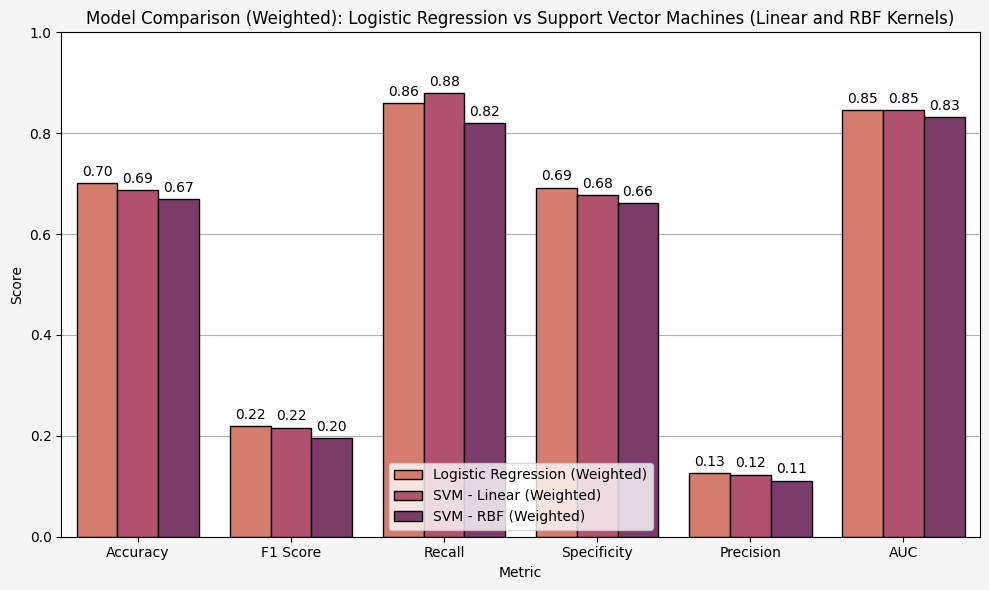

In [77]:
# Lets visualize the results once again
# Plot comparison
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Multiple Bar plot:
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="flare", edgecolor="black", zorder=2)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)
    
plt.title("Model Comparison (Weighted): Logistic Regression vs Support Vector Machines (Linear and RBF Kernels)")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.legend(loc="lower center")
plt.tight_layout()
plt.show()

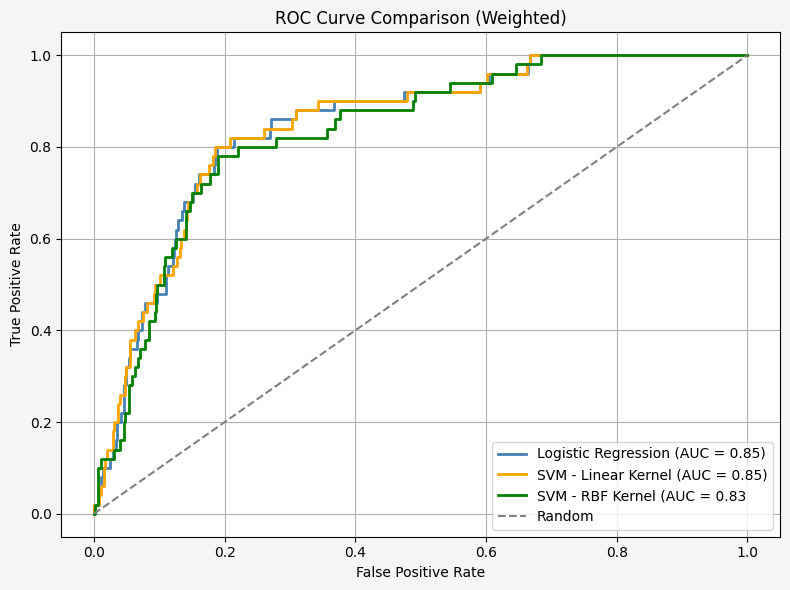

In [78]:
# Lets plot ROC-AUC curves for these models as well
# Compute ROC curves and AUC
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
fpr_svm_lin, tpr_svm_lin, _ = roc_curve(y_test, svm_lin_proba)
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, svm_rbf_proba)

auc_log = auc(fpr_log, tpr_log)
auc_svm_lin = auc(fpr_svm_lin, tpr_svm_lin)
auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

# Plot ROC curves
plt.figure(figsize=(8, 6), facecolor="whitesmoke")
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})", linewidth=2, color="steelblue")
plt.plot(fpr_svm_lin, tpr_svm_lin, label=f"SVM - Linear Kernel (AUC = {auc_svm_lin:.2f})", linewidth=2, color="orange")
plt.plot(fpr_svm_rbf, tpr_svm_rbf, label=f"SVM - RBF Kernel (AUC = {auc_svm_rbf:.2f}", linewidth=2, color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Weighted)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
# Once again lets also test for overfitting
# Train set predictions
log_train_pred = log_reg_w.predict(X_train)
svm_lin_train_pred = svm_linear_w.predict(X_train)
svm_rbf_train_pred = svm_rbf_w.predict(X_train)

# Recall on train set
log_train_recall = recall_score(y_train, log_train_pred)
svm_lin_train_recall = recall_score(y_train, svm_lin_train_pred)
svm_rbf_train_recall = recall_score(y_train, svm_rbf_train_pred)

# Recall on test set
log_test_recall = recall_score(y_test, log_pred)
svm_lin_test_recall = recall_score(y_test, svm_lin_pred)
svm_rbf_test_recall = recall_score(y_test, svm_rbf_pred)

# Print comparison
print(f"Logistic Regression - Train Recall: {log_train_recall:.2f} | Test Recall: {log_test_recall:.2f}")
print(f"SVM Linear - Train Recall: {svm_lin_train_recall:.2f} | Test Recall: {svm_lin_test_recall:.2f}")
print(f"SVM RBF - Train Recall: {svm_rbf_train_recall:.2f} | Test Recall: {svm_rbf_test_recall:.2f}")

Logistic Regression - Train Recall: 0.81 | Test Recall: 0.86
SVM Linear - Train Recall: 0.82 | Test Recall: 0.88
SVM RBF - Train Recall: 0.81 | Test Recall: 0.82


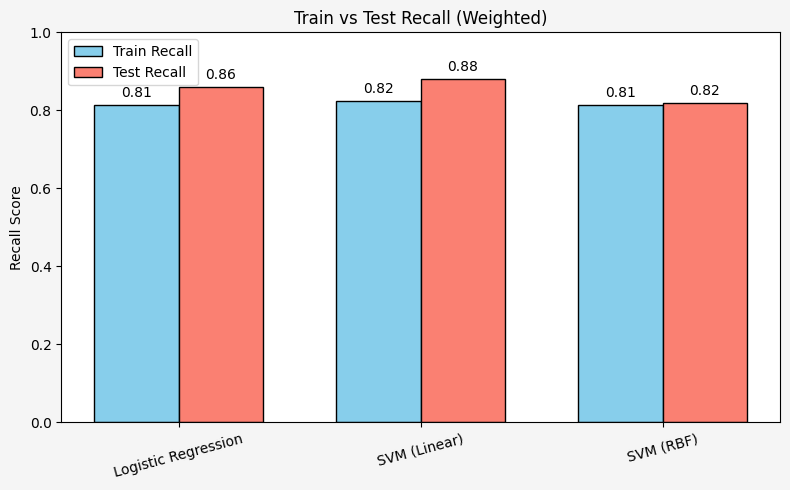

In [80]:
# Lets plot everything so we can examine the metrics more easily and consicely
models = ["Logistic Regression", "SVM (Linear)", "SVM (RBF)"]
train_recalls = [log_train_recall, svm_lin_train_recall, svm_rbf_train_recall]
test_recalls = [log_test_recall, svm_lin_test_recall, svm_rbf_test_recall]

# Bar plot setup
bar_width = 0.35
x = range(len(models))

plt.figure(figsize=(8, 5), facecolor="whitesmoke")
plt.bar(x, train_recalls, width=bar_width, label="Train Recall", color="skyblue", edgecolor="black")
plt.bar([p + bar_width for p in x], test_recalls, width=bar_width, label="Test Recall", color="salmon", edgecolor="black")

# Label setup
plt.xticks([p + bar_width / 2 for p in x], models, rotation=15)
plt.ylabel("Recall Score")
plt.ylim(0, 1)
plt.title("Train vs Test Recall (Weighted)")
plt.legend()

# Annotate bars with values
for i, (train, test) in enumerate(zip(train_recalls, test_recalls)):
    plt.text(i, train + 0.02, f"{train:.2f}", ha='center')
    plt.text(i + bar_width, test + 0.02, f"{test:.2f}", ha='center')

plt.tight_layout()
plt.show()

###

### Thoughts for this weighted-model phase:

#### This class-weighted method seems to have returned the highest Recall scores observed across all experiments so far, with the Logistic Regression and SVM (Linear Kernel) models achieving Recall values of 0.86 and 0.88 respectively, while also maintaining high AUC scores ( about 0.845). 

#### Overfitting checks showed minimal train-test recall discrepancy, indicating excellent generalization. These results strongly suggest that class weighting is highly effective for this prediction task, with SVM (Linear, Weighted) emerging as the most robust model overall.

###

### Next Phase: Hyper-parameter tuning for the strongest models
#### It would seem like a could experimental addition, to see if we can squeeze out a bit of higher performance out of these models, using GridSearchCV.
#### To do that, I will choose the sampling strategy for each of these models, under which the model performed best.
#### This way we will be optimizing each model in its most favorable conditions, and making sure we are squeezing out real potential gains, and not just noise.

###

### Best Models by Sampling Strategy (Top 3 Metrics: Recall, Specificity, ROC-AUC)

#### Lets summarize the best performers a little bit:

|Model	|Sampling Strategy	|Recall	|Specificity	|AUC	|Verdict|
|:------|:------------------|:------|:--------------|:------|:------|
|Logistic Regression|	Weighted	|0.86	|0.69	|0.845	|High Recall - solid Specificity|
|Logistic Regression|	Downsampling	|0.78	|0.78	|0.84	|Balanced good results overall|
|SVM (Linear Kernel)|	Weighted	|0.88	|0.68	|0.846	|Highest Recall - high AUC|
|SVM (RBF Kernel)	|Full SMOTE	|0.84	|0.65	|0.836	|High Recall - balanced AUC|
|Logistic Regression|Downsampling|	0.78	|0.78	|0.838	|Very balanced, strong AUC|
|SVM (Linear Kernel) |Downsampling|	0.84|	0.75|	0.838|Excellent balance|
|SVM (RBF Kernel) |	Reduced SMOTE	|0.80|	0.74	|0.839	|Great all-around|


#### Final Best Sampling-Model Pairings:

|Model	|Sampling Strategy|	Reasoning|
|:------|:---------------|:------------|
|Logistic Regression	|Downsampling	|Good Recall (0.78), strong AUC, decent Specificity|
|SVM (Linear Kernel)		|Weighted	|excellent Recall (0.88), high Specificity (0.68), great AUC (0.85)|
|SVM (RBF Kernel)	|Reduced SMOTE	|slightly more balanced than Full SMOTE (Recall, Specificity, AUC all about 0.80–0.84)|

###

#### Lets start optimizing the selected models:

### Logistic Regression (Downsampling):

In [82]:
# GridSearchCV and model setup
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Hyperparameter grid setup
logreg_params = [{'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs']},
                 {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}]

# Grid Search
grid_logreg = GridSearchCV(estimator=logreg,
                           param_grid=logreg_params,
                           scoring=make_scorer(recall_score),
                           cv=5,
                           n_jobs=-1,
                           verbose=1)


In [83]:
# Fitting the model and getting the best parameters
grid_logreg.fit(X_train_down, y_train_down)
print("Best parameters (Logistic Regression):", grid_logreg.best_params_)
best_logreg = grid_logreg.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters (Logistic Regression): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


###

### SVM - Linear Kernel (Weighted)

In [84]:
# GridSearchCV and model setup
svm_lin = SVC(class_weight='balanced', probability=True, random_state=42)

# Hyperparameter grid setup
svm_linear_params = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear']}

# Grid Search
grid_svm_linear = GridSearchCV(estimator=svm_lin,
                               param_grid=svm_linear_params,
                               scoring=make_scorer(recall_score),
                               cv=5,
                               n_jobs=-1,
                               verbose=1)


In [85]:
# Fitting the model and getting the best parameters
grid_svm_linear.fit(X_train, y_train)
print("Best parameters (SVM Linear):", grid_svm_linear.best_params_)
best_svm_linear = grid_svm_linear.best_estimator_


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters (SVM Linear): {'C': 1, 'kernel': 'linear'}


###

### SVM - RBF Kernel (Reduced SMOTE)

In [86]:
# GridSearchCV and model setup
svm_rbf = SVC(class_weight='balanced', probability=True, random_state=42)

# Hyperparameter grid setup
svm_rbf_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}

# Grid Search
grid_svm_rbf = GridSearchCV(estimator=svm_rbf,
                            param_grid=svm_rbf_params,
                            scoring=make_scorer(recall_score),
                            cv=5,
                            n_jobs=-1,
                            verbose=1)


In [87]:
# Fitting the model and getting the best params
grid_svm_rbf.fit(X_train_smote_red, y_train_smote_red)
print("Best parameters (SVM RBF):", grid_svm_rbf.best_params_)
best_svm_rbf = grid_svm_rbf.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters (SVM RBF): {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


###

#### Lets fit the best models once again each with the corresponding sampling strategy, and collect the final metrics.

In [88]:
# Logistic Regression (downsampling)
best_logreg.fit(X_train_down, y_train_down)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

In [89]:
# SVM - Linear Kernel (weighted)
best_svm_linear.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)

In [90]:
# SVM - RBF Kernel (reduced SMOTE)
best_svm_rbf.fit(X_train_smote_red, y_train_smote_red)

SVC(C=10, class_weight='balanced', gamma='auto', probability=True,
    random_state=42)

In [91]:
# Now lets once again make some predictions and collect the probabilities for the ROC Analysis
# Predict on test set
log_pred = best_logreg.predict(X_test)
svm_lin_pred = best_svm_linear.predict(X_test)
svm_rbf_pred = best_svm_rbf.predict(X_test)

# Probabilities for AUC
log_proba = best_logreg.predict_proba(X_test)[:, 1]
svm_lin_proba = best_svm_linear.predict_proba(X_test)[:, 1]
svm_rbf_proba = best_svm_rbf.predict_proba(X_test)[:, 1]


In [92]:
# Now lets collect the metrics and check out the performance
# Initialize dictionaries for each metric:
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}

# Collect metrics
collect_metrics("Logistic Regression (Tuned)", y_test, log_pred, log_proba)
collect_metrics("SVM - Linear (Tuned)", y_test, svm_lin_pred, svm_lin_proba)
collect_metrics("SVM - RBF (Tuned)", y_test, svm_rbf_pred, svm_rbf_proba)

results_df = pd.DataFrame(metrics)

In [93]:
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Logistic Regression (Tuned),0.695481,0.217172,0.86,0.686983,0.124277,0.837169
1,SVM - Linear (Tuned),0.686640,0.216216,0.88,0.676653,0.123249,0.846157
2,SVM - RBF (Tuned),0.888998,0.175182,0.24,0.922521,0.137931,0.641157


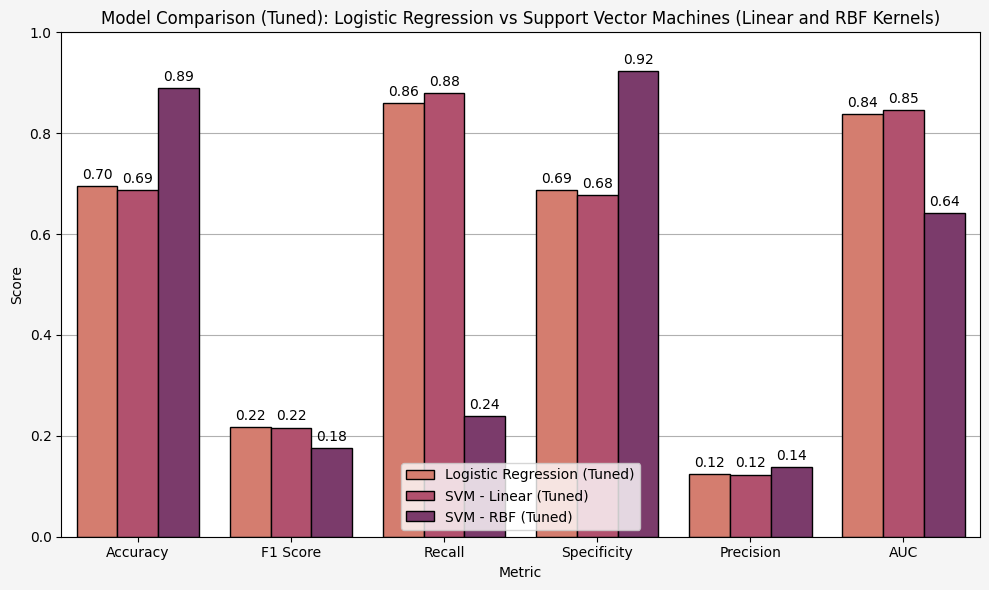

In [94]:
# Lets visualize the results once again
# Plot comparison
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Multiple Bar plot:
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="flare", edgecolor="black", zorder=2)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)
    
plt.title("Model Comparison (Tuned): Logistic Regression vs Support Vector Machines (Linear and RBF Kernels)")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.legend(loc="lower center")
plt.tight_layout()
plt.show()

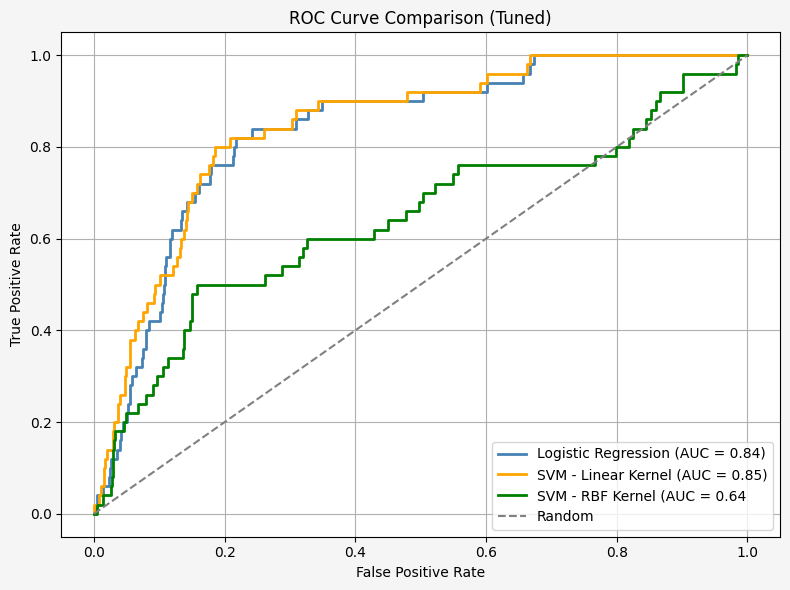

In [95]:
# Lets plot ROC-AUC curves for these models as well
# Compute ROC curves and AUC
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
fpr_svm_lin, tpr_svm_lin, _ = roc_curve(y_test, svm_lin_proba)
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, svm_rbf_proba)

auc_log = auc(fpr_log, tpr_log)
auc_svm_lin = auc(fpr_svm_lin, tpr_svm_lin)
auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

# Plot ROC curves
plt.figure(figsize=(8, 6), facecolor="whitesmoke")
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})", linewidth=2, color="steelblue")
plt.plot(fpr_svm_lin, tpr_svm_lin, label=f"SVM - Linear Kernel (AUC = {auc_svm_lin:.2f})", linewidth=2, color="orange")
plt.plot(fpr_svm_rbf, tpr_svm_rbf, label=f"SVM - RBF Kernel (AUC = {auc_svm_rbf:.2f}", linewidth=2, color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Tuned)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
# Once again lets also test for overfitting
# Train set predictions
log_train_pred = log_reg_w.predict(X_train)
svm_lin_train_pred = svm_linear_w.predict(X_train)
svm_rbf_train_pred = svm_rbf_w.predict(X_train)

# Recall on train set
log_train_recall = recall_score(y_train, log_train_pred)
svm_lin_train_recall = recall_score(y_train, svm_lin_train_pred)
svm_rbf_train_recall = recall_score(y_train, svm_rbf_train_pred)

# Recall on test set
log_test_recall = recall_score(y_test, log_pred)
svm_lin_test_recall = recall_score(y_test, svm_lin_pred)
svm_rbf_test_recall = recall_score(y_test, svm_rbf_pred)

# Print comparison
print(f"Logistic Regression - Train Recall: {log_train_recall:.2f} | Test Recall: {log_test_recall:.2f}")
print(f"SVM Linear - Train Recall: {svm_lin_train_recall:.2f} | Test Recall: {svm_lin_test_recall:.2f}")
print(f"SVM RBF - Train Recall: {svm_rbf_train_recall:.2f} | Test Recall: {svm_rbf_test_recall:.2f}")

Logistic Regression - Train Recall: 0.81 | Test Recall: 0.86
SVM Linear - Train Recall: 0.82 | Test Recall: 0.88
SVM RBF - Train Recall: 0.81 | Test Recall: 0.24


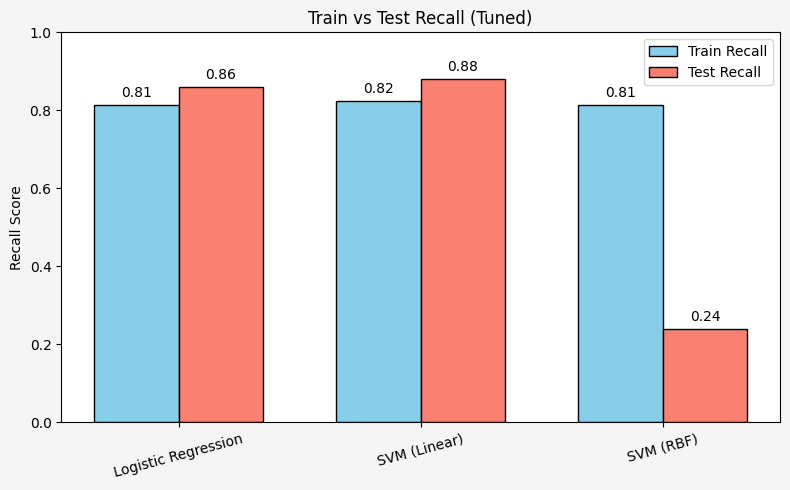

In [97]:
# Lets plot everything so we can examine the metrics more easily and consicely
models = ["Logistic Regression", "SVM (Linear)", "SVM (RBF)"]
train_recalls = [log_train_recall, svm_lin_train_recall, svm_rbf_train_recall]
test_recalls = [log_test_recall, svm_lin_test_recall, svm_rbf_test_recall]

# Bar plot setup
bar_width = 0.35
x = range(len(models))

plt.figure(figsize=(8, 5), facecolor="whitesmoke")
plt.bar(x, train_recalls, width=bar_width, label="Train Recall", color="skyblue", edgecolor="black")
plt.bar([p + bar_width for p in x], test_recalls, width=bar_width, label="Test Recall", color="salmon", edgecolor="black")

# Label setup
plt.xticks([p + bar_width / 2 for p in x], models, rotation=15)
plt.ylabel("Recall Score")
plt.ylim(0, 1)
plt.title("Train vs Test Recall (Tuned)")
plt.legend()

# Annotate bars with values
for i, (train, test) in enumerate(zip(train_recalls, test_recalls)):
    plt.text(i, train + 0.02, f"{train:.2f}", ha='center')
    plt.text(i + bar_width, test + 0.02, f"{test:.2f}", ha='center')

plt.tight_layout()
plt.show()

###

### Final Results Summary (for the tuned models):

|Model	|Accuracy|	Recall	|Specificity|	AUC|	Verdict|
|:-----|:---|:----|:----|:----|:---|
|LogReg (Tuned)|	0.701	|0.86|	0.69|	0.84	|Still strong, but slightly edged out|
|SVM Linear (Tuned)	|0.693	|0.88	|0.68	|0.85	|Highest Recall, balanced, stable|
|SVM RBF (Tuned)	|0.889	|0.24	|0.92	|0.641	|Overfitting, lost its earlier edge|

#### The SVM (Linear Kernel) has the highest Recall (0.88), good Specificity (0.68), AUC performance close to top and stable performance acroos all stages.
#### The SVM (RBF Kernel) seemed to completely collapse as far as Recall is concerned, extremely overfitting to the majority negative class of the target.
#### The Logistic Regression model is still respectable, but a little behind the SVM (Linear Kernel) in Recall, in this trial. 

###

### Last training phase: Neural Networks 

#### Now I am going to include some Neural Networks experimentation, to finish the modeling phase and decide on the final best model.
#### The plan is the following:
#### 1. Try s Two-Class Averaged Perceptron model.
#### 2. Try a Two-Class Neural Network (Feed-forward).
#### 3. Try a transfer-learning approach using TabNet.

###

#### As far as sampling strategies are concerned, I will again include the three strategies we tried above:
#### - Full SMOTE oversampling
#### - Reduced SMOTE oversampling
#### - Downsampling approach

###

### Neural Networks Trial 1 (Full SMOTE Oversampling)

In [97]:
# Lets start with the Perceptron model
# Train Perceptron
perceptron = Perceptron(max_iter=1000, random_state=42)
perceptron.fit(X_train_smote, y_train_smote)


Perceptron(random_state=42)

In [98]:
# Predict on test set
perc_pred = perceptron.predict(X_test)

# Define and collect metrics
# The perceptron doesn't support prediction of probabilities for the AUC (hard-margin classifier)
# We will use the true predictions that it makes on the test set
# This approach is a bit less precise, but still valid
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}
collect_metrics("Perceptron", y_test, perc_pred)


In [99]:
# Lets move on the FFNN model
# Define FFNN model:
# (I will use a function in which we will be able to switch the training data input easily, later)
def create_ffnn(input_dim):
    model = keras.models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['recall'])
    return model


In [100]:
# Train the FFNN model
ffnn = create_ffnn(X_train_smote.shape[1])
history = ffnn.fit(X_train_smote, y_train_smote, validation_data=(X_test, y_test),
                   epochs=20, batch_size=32, verbose=0)

In [101]:
# Predict & collect metrics
ffnn_probs = ffnn.predict(X_test).flatten()
ffnn_pred = (ffnn_probs >= 0.5).astype(int)
collect_metrics("FFNN", y_test, ffnn_pred, y_proba=ffnn_probs)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [102]:
# Check out the metrics for both models
results_df = pd.DataFrame(metrics)
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Perceptron,0.805501,0.238462,0.62,0.815083,0.147619,0.717541
1,FFNN,0.806483,0.215139,0.54,0.820248,0.134328,0.777004


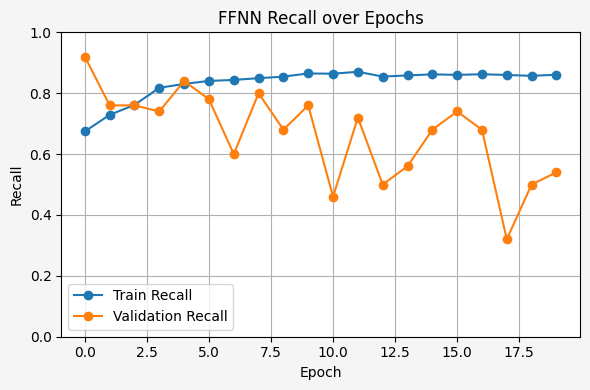

In [103]:
# Plot recall evolution to check overfitting of the FFNN
plt.figure(figsize=(6, 4), facecolor="whitesmoke")
plt.plot(history.history['recall'], label='Train Recall', marker='o')
plt.plot(history.history['val_recall'], label='Validation Recall', marker='o')
plt.title("FFNN Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

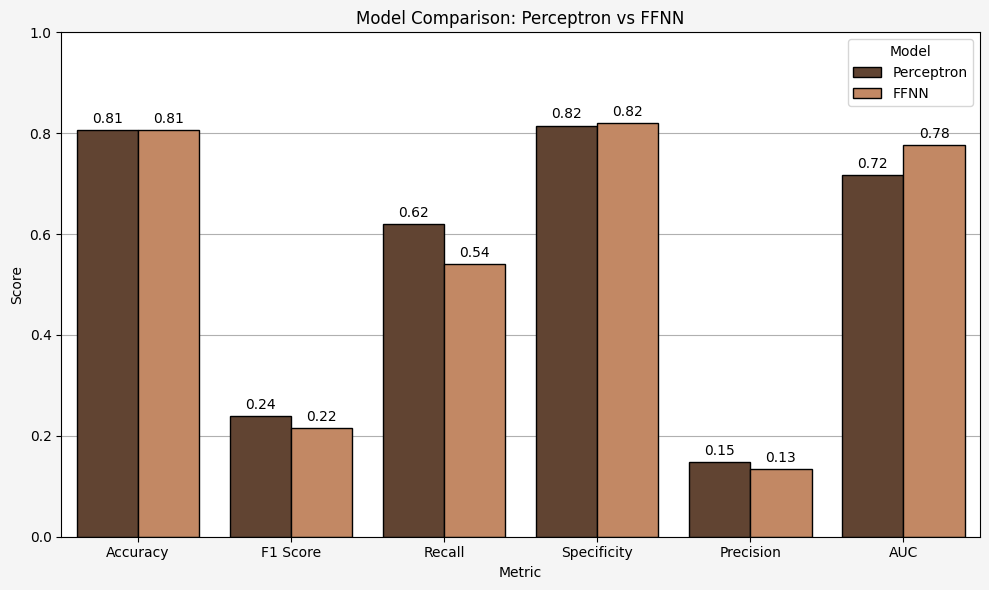

In [104]:
# lets visualize the results fro these two models
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="copper", edgecolor="black", zorder=2)

# Annotate
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)

plt.title("Model Comparison: Perceptron vs FFNN")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.tight_layout()
plt.show()

###

#### As is evident from the multiple barplot and especially the train/validation Recall overfitting check, the FFNN model starts overfitting early, at about the 4th epoch. I think it is worth a try to tweek it a little bit, and see if we can squeeze a out higher Recall score, since Accuracy, Specificity and AUC are already at a quite nice level.

In [105]:
# Lets build another standalone model with some tweeks
ffnn2 = Sequential()
ffnn2.add(Input(shape=(X_train_smote.shape[1],)))
ffnn2.add(Dense(64, activation='relu'))
ffnn2.add(Dropout(0.3))
ffnn2.add(Dense(32, activation='relu'))
ffnn2.add(Dense(1, activation='sigmoid'))

# Compile the model
# One addition will be a lower learning rate:
ffnn2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['recall'])

# Another addition we can try is early stopping"
early_stop = EarlyStopping(monitor='val_recall', patience=2, mode='max', restore_best_weights=True)


In [106]:
# Train the new model (using 4 epochs this time)
history2 = ffnn2.fit(X_train_smote, y_train_smote,
                     validation_data=(X_test, y_test),
                     epochs=4, batch_size=32,
                     callbacks=[early_stop], verbose=0)


In [107]:
# Predictions and metrics collection
ffnn2_probs = ffnn2.predict(X_test).flatten()
ffnn2_pred = (ffnn2_probs >= 0.5).astype(int)
collect_metrics("FFNN (4 Epochs)", y_test, ffnn2_pred, y_proba=ffnn2_probs)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [108]:
# Check out the metrics for all models once again
results_df = pd.DataFrame(metrics)
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Perceptron,0.805501,0.238462,0.62,0.815083,0.147619,0.717541
1,FFNN,0.806483,0.215139,0.54,0.820248,0.134328,0.777004
2,FFNN (4 Epochs),0.542240,0.161871,0.90,0.523760,0.088933,0.814360


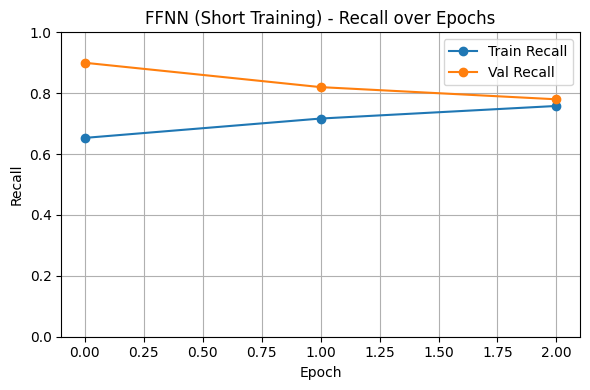

In [109]:
# Plot recall tracking to check for overfitting once again
plt.figure(figsize=(6, 4))
plt.plot(history2.history['recall'], label='Train Recall', marker='o')
plt.plot(history2.history['val_recall'], label='Val Recall', marker='o')
plt.title("FFNN (Short Training) - Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


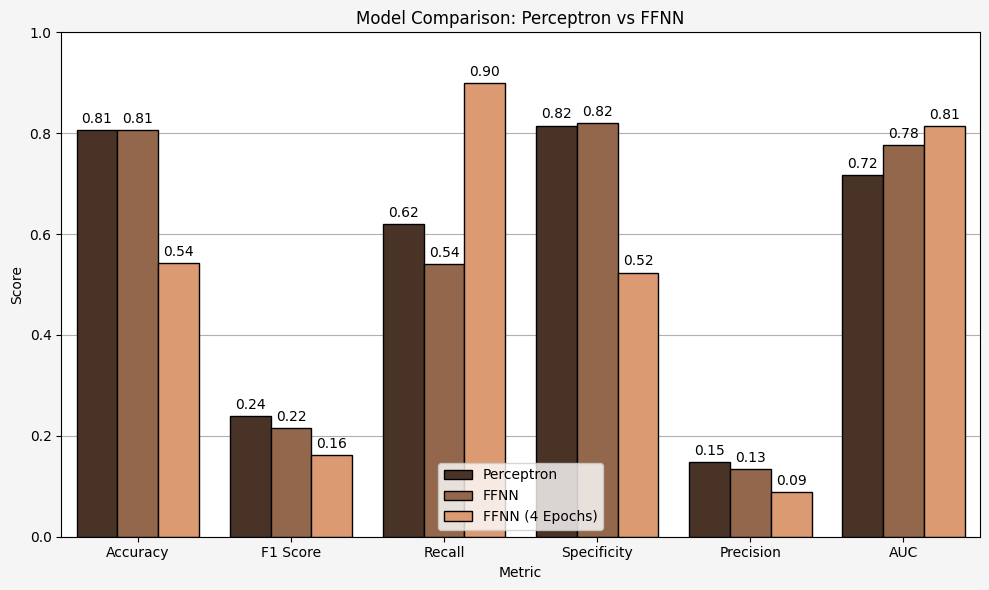

In [110]:
# lets visualize the final results of all these three trials
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="copper", edgecolor="black", zorder=2)

# Annotate
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)

plt.title("Model Comparison: Perceptron vs FFNN")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.legend(loc="lower center")
plt.tight_layout()
plt.show()

###

#### So in this Full SMOTE trial:
#### - The Perceptron classifier achieved solid and stable results, with a Recall of 0.62 and balanced Specificity (0.81). 
#### - The standard FFNN initially trained over 20 epochs performed slightly below the Perceptron, achieving a Recall of 0.54.
#### - However, retraining the FFNN with only 4 epochs led to a significant boost in Recall (0.90), indicating that shorter training cycles helped prevent overfitting and allowed the model to better capture the signal from the minority class. 

#### While this came at the cost of lower accuracy and specificity, it suggests that FFNNs are particularly sensitive to overfitting in oversampled data, and careful tuning of epochs or early stopping is probably crucial for optimizing Recall without sacrificing generalization.

###

#### A few thoughts about the low Precision:
#### Across both FFNN models (particularly the second one trained for 4 epochs) Precision values remained very low. This might be expected and understandable given the highly imbalanced nature of the dataset. Since SMOTE oversampling was used in training (but not applied to the test set), models trained on a balanced set might be overly..."eager" to predict positives, even when applied to an imbalanced real-world test distribution. This might cause many false positives, which in turn lowers Precision. However, in the context of stroke prediction, maximizing Recall is typically prioritized, as false negatives (missed stroke risks) are costlier than false positives. Therrefore, low Precision is probably an acceptable tradeoff as long as it accompanies a high Recall and strong AUC.

###

### Neural Networks Trial 2 (Reduced SMOTE Oversampling)

In [111]:
# Lets start with the Perceptron model once again
# Train Perceptron on the reduced SMOTE data
perceptron = Perceptron(max_iter=1000, random_state=42)
perceptron.fit(X_train_smote_red, y_train_smote_red)


Perceptron(random_state=42)

In [112]:
# Predict on test set
perc_pred = perceptron.predict(X_test)

# Define and collect metrics again
# The re-definition of the metrics dictionary will make sure that we only include the models trained in this phase
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}
collect_metrics("Perceptron", y_test, perc_pred)


In [113]:
# Define and Train the initial FFNN model (based on the previous function I defined)
ffnn = create_ffnn(X_train_smote_red.shape[1])
history = ffnn.fit(X_train_smote_red, y_train_smote_red, validation_data=(X_test, y_test),
                   epochs=20, batch_size=32, verbose=0)

In [114]:
# Predict & collect metrics
ffnn_probs = ffnn.predict(X_test).flatten()
ffnn_pred = (ffnn_probs >= 0.5).astype(int)
collect_metrics("FFNN", y_test, ffnn_pred, y_proba=ffnn_probs)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [115]:
# Check out the metrics for both models
results_df = pd.DataFrame(metrics)
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Perceptron,0.869352,0.248588,0.44,0.891529,0.173228,0.665764
1,FFNN,0.810413,0.178723,0.42,0.830579,0.113514,0.760744


#### Both models seem to behave really badly with the reduced smote data. 
#### Lets try the tuned FFNN again and see how it generalizes in this situation:

In [116]:
# Standalone FFNN model with the same tweeks
ffnn2 = Sequential()
ffnn2.add(Input(shape=(X_train_smote.shape[1],)))
ffnn2.add(Dense(64, activation='relu'))
ffnn2.add(Dropout(0.3))
ffnn2.add(Dense(32, activation='relu'))
ffnn2.add(Dense(1, activation='sigmoid'))

# Compile the model
# One addition will be a lower learning rate:
ffnn2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['recall'])

# Another addition we can try is early stopping"
early_stop = EarlyStopping(monitor='val_recall', patience=2, mode='max', restore_best_weights=True)


In [117]:
# Train the new model (using 4 epochs this time)
history2 = ffnn2.fit(X_train_smote, y_train_smote,
                     validation_data=(X_test, y_test),
                     epochs=4, batch_size=32,
                     callbacks=[early_stop], verbose=0)

In [118]:
# Predictions and metrics collection
ffnn2_probs = ffnn2.predict(X_test).flatten()
ffnn2_pred = (ffnn2_probs >= 0.5).astype(int)
collect_metrics("FFNN (4 Epochs)", y_test, ffnn2_pred, y_proba=ffnn2_probs)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [119]:
# Check out the metrics for all models once again
results_df = pd.DataFrame(metrics)
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Perceptron,0.869352,0.248588,0.44,0.891529,0.173228,0.665764
1,FFNN,0.810413,0.178723,0.42,0.830579,0.113514,0.760744
2,FFNN (4 Epochs),0.504912,0.151515,0.90,0.484504,0.082721,0.814483


###

#### Summary of the Reduced-SMOTE phase:
#### - Under the reduced SMOTE strategy, both the Perceptron and the FFNN models showed weakened performance compared to the full SMOTE run, with Recall values of 0.44 and 0.42 respectively. 
#### - This suggests that reducing the number of synthetic minority class examples may have limited the models' exposure to the stroke class, reducing their ability to generalize. 
#### - However, once again, a 4-epoch FFNN significantly improved Recall, reaching 0.90 — the highest in this phase — but at the cost of much lower Accuracy and Specificity. This is similar to the earlier findings and reinforces the idea that shorter training cycles for neural networks on oversampled data can greatly improve Sensitivity, though with a tradeoff in false positives (low Precision) and misclassifications of the majority class.

###

#### On low Precision again:

#### As with the previous Full-SMOTE run, the Precision values remained low across all models. This again probably reflects the discrepancy between the balanced training set and the imbalanced test set, where the model's confidence in predicting stroke leads to a higher false positive rate. Like I metnioned before, while this impacts Precision, the tradeoff may be acceptable in health-focused applications where missing true stroke cases is more critical than issuing false alerts. These results highlight the importance of interpreting metrics in context and aligning model objectives with domain-specific priorities.

###

### Neural Networks Trial 3 (Downsampling)

In [120]:
# Lets start with the Perceptron model once again
# Train Perceptron on the downsampled data
perceptron = Perceptron(max_iter=1000, random_state=42)
perceptron.fit(X_train_down, y_train_down)

Perceptron(random_state=42)

In [121]:
# Predict on test set
perc_pred = perceptron.predict(X_test)

# Define and collect metrics again
# The re-definition of the metrics dictionary will make sure that we only include the models trained in this phase
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}
collect_metrics("Perceptron", y_test, perc_pred)

In [122]:
# Define and Train the initial FFNN model (based on the previous function I defined)
ffnn = create_ffnn(X_train_down.shape[1])
history = ffnn.fit(X_train_down, y_train_down, validation_data=(X_test, y_test),
                   epochs=20, batch_size=32, verbose=0)

In [123]:
# Predict & collect metrics
ffnn_probs = ffnn.predict(X_test).flatten()
ffnn_pred = (ffnn_probs >= 0.5).astype(int)
collect_metrics("FFNN", y_test, ffnn_pred, y_proba=ffnn_probs)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [124]:
# Check out the metrics for both models
results_df = pd.DataFrame(metrics)
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,Perceptron,0.851670,0.248756,0.50,0.869835,0.165563,0.684917
1,FFNN,0.858546,0.265306,0.52,0.876033,0.178082,0.803058


#### I think it is worth to check for overfitting once more, and see if another tweeked version might be in order.

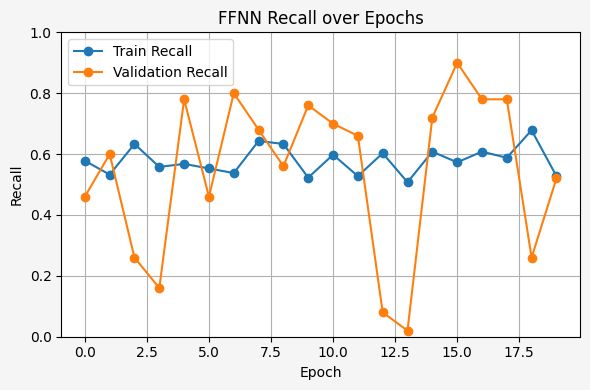

In [125]:
# Plot recall evolution to check overfitting of the FFNN
plt.figure(figsize=(6, 4), facecolor="whitesmoke")
plt.plot(history.history['recall'], label='Train Recall', marker='o')
plt.plot(history.history['val_recall'], label='Validation Recall', marker='o')
plt.title("FFNN Recall over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

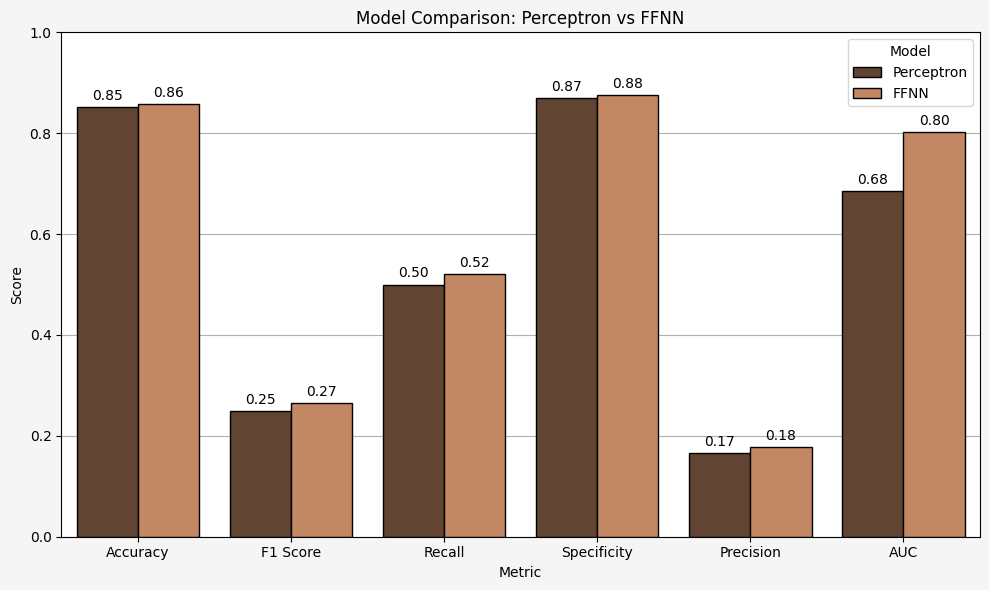

In [126]:
# lets visualize the results fro these two models
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="copper", edgecolor="black", zorder=2)

# Annotate
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)

plt.title("Model Comparison: Perceptron vs FFNN")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.tight_layout()
plt.show()

###

#### Final words for this phase:

#### So in this Downsampling strategy phase, we notice that both models have low/indifferent Recall, and the FFNN has become a bit more stable across our main metrics. However, the overfitting check reveals that the model has completely erratic behavior, as far as Validation Recall is concenrned.

#### - The erratic behavior of validation recall from epoch to epoch might indicate high variance in model learning from batch to batch (common with smaller datasets like downsampled sets).

#### - There is no clear overfitting pattern (for example, no consistent upward trend for train recall and downward for Validation Recall).

#### The model likely seems to have sensitivity to initialization or batch composition, which causes unstable validation signals.

#### In other words, the FFNN in this trail probably isn't overfitting, but it is just inconsistent. And that inconsistency makes further tuning (for example epochs, learning rate, etc.) most likely completely pointless.

###

### Neural Networks Trial 4 - Transfer Learning approach using TabNet

#### Following all three sampling strategies we have used so far, in this last ran I am going to give TabNet a try.

####

#### Tabnet Trial 1 (Full SMOTE)

In [98]:
# Lets start with defining the metrics dictionary cleanly once again
# This way I will collect all metrics for all three trials and diplay them all at the end, for easier comparisons
metrics = {"Model": [], "Accuracy": [], "F1 Score": [], "Recall": [], "Specificity": [], "Precision": [], "AUC": []}

In [99]:
# Define and train the model using the full SMOTE sampling strategy
tabnet_full_smote = TabNetClassifier(verbose=0, seed=42)
tabnet_full_smote.fit(X_train_smote.values, y_train_smote.values,
                      eval_set=[(X_test.values, y_test.values)],
                      eval_name=["val"], eval_metric=["auc"],
                      max_epochs=100, patience=10, batch_size=1024)


Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_auc = 0.75846


In [100]:
# Make predictions and obtain probabilities
preds_full_smote = tabnet_full_smote.predict(X_test.values)
probas_full_smote = tabnet_full_smote.predict_proba(X_test.values)[:, 1]

In [101]:
# Collect the metrics for this model
collect_metrics("TabNet (Full SMOTE)", y_test, preds_full_smote, probas_full_smote)

####

#### TabNet Trial 2 (Reduced SMOTE)

In [102]:
tabnet_reduced_smote = TabNetClassifier(verbose=0, seed=42)

In [103]:
tabnet_reduced_smote.fit(X_train_smote_red.values, y_train_smote_red.values,
                         eval_set=[(X_test.values, y_test.values)],
                         eval_name=["val"], eval_metric=["auc"],
                         max_epochs=100, patience=10, batch_size=1024)


Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_auc = 0.7909


In [104]:
# Make predictions/obtain probabilities for this model as well
preds_reduced_smote = tabnet_reduced_smote.predict(X_test.values)
probas_reduced_smote = tabnet_reduced_smote.predict_proba(X_test.values)[:, 1]

In [105]:
# Finally, collect the metrics again
collect_metrics("TabNet (Reduced SMOTE)", y_test, preds_reduced_smote, probas_reduced_smote)

####

#### TabNet Trial 3 (Downsampling)

In [106]:
# Define the model for the downsampling strategy
tabnet_downsampling = TabNetClassifier(verbose=0, seed=42)

In [107]:
# Train the model
tabnet_downsampling.fit(X_train_down.values, y_train_down.values, 
                        eval_set=[(X_test.values, y_test.values)],
                        eval_name=["val"], eval_metric=["auc"],
                        max_epochs=100, patience=10, batch_size=1024)


Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_auc = 0.41056


In [108]:
# Make predictions/obtain probabilities
preds_downsampling = tabnet_downsampling.predict(X_test.values)
probas_downsampling = tabnet_downsampling.predict_proba(X_test.values)[:, 1]

In [109]:
# Collect metrics one last time
collect_metrics("TabNet (Downsampling)", y_test, preds_downsampling, probas_downsampling)

####

#### Evaluation time!

In [110]:
# Lets cheeck out the results in a dataframe 
results_df = pd.DataFrame(metrics)
results_df

,Model,Accuracy,F1 Score,Recall,Specificity,Precision,AUC
0,TabNet (Full SMOTE),0.557957,0.150943,0.80,0.545455,0.083333,0.758461
1,TabNet (Reduced SMOTE),0.766208,0.190476,0.56,0.776860,0.114754,0.790899
2,TabNet (Downsampling),0.939096,0.000000,0.00,0.987603,0.000000,0.410558


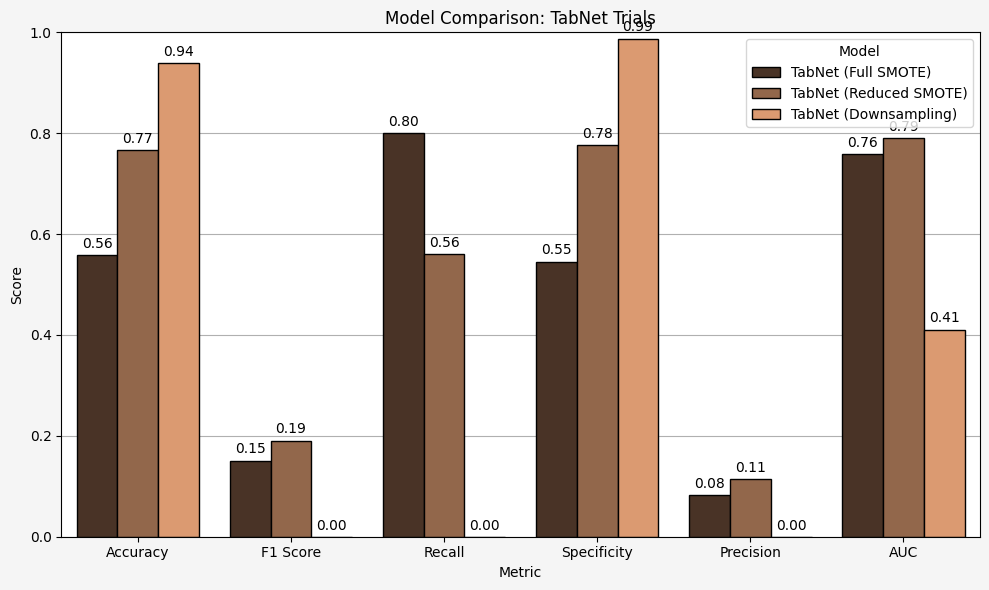

In [111]:
# lets once again also visualize the results in a barplot
melted = results_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(10, 6), facecolor="whitesmoke")
ax = sns.barplot(data=melted, x="Metric", y="Score", hue="Model", palette="copper", edgecolor="black", zorder=2)

# Annotate
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3, fontsize=10)

plt.title("Model Comparison: TabNet Trials")
plt.ylim(0, 1)
plt.grid(axis="y", zorder=0)
plt.tight_layout()
plt.show()

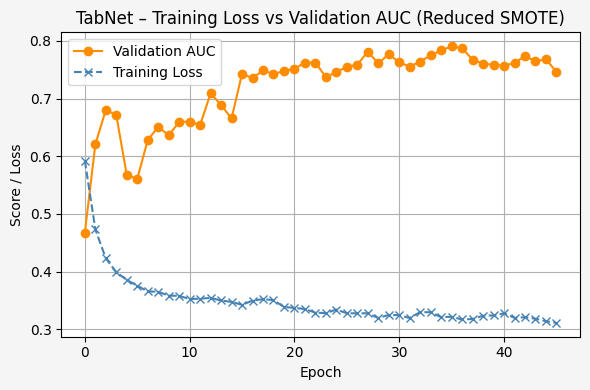

In [112]:
# The reduced-SMOTE TabNet run seems to me to have the most balanced results
# Lets also check this model for overfitting
# Unfortunately TabNet doesn't seem to track training Recall or Precision

# Extract AUC history from model
train_auc = tabnet_reduced_smote.history["loss"] # This is the training Loss, technically the "training AUC"
val_auc = tabnet_reduced_smote.history["val_auc"] # This is the validation AUC

# Plot both metrics for comparison
plt.figure(figsize=(6, 4), facecolor="whitesmoke")
plt.plot(val_auc, label="Validation AUC", marker='o', linestyle='-', color='darkorange')
plt.plot(train_auc, label="Training Loss", marker='x', linestyle='--', color='steelblue')

plt.title("TabNet – Training Loss vs Validation AUC (Reduced SMOTE)")
plt.xlabel("Epoch")
plt.ylabel("Score / Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


####

#### TabNet Trials Conclusions:

#### The TabNet experiments across the three sampling strategies revealed meaningful insights. 
#### Among the models tested, TabNet combined with the Reduced-SMOTE strategy achieved the best overall balance between recall (0.56) and AUC (0.79).
#### However, this performance is still behind other classifiers we trained, such as SVM (Linear Kernel) and Logistic Regression (Weighted). 
#### It is worth mentioning that the Downsampling run with TabNet failed to identify any stroke cases, with recall and precision dropping to zero: highlighting the sensitivity of TabNet to class imbalance when trained without augmentation (or in datasets with not enough size).

#### Although promising in some aspects, TabNet did not outperform simpler models in this particular task, and was therefore not selected as the final model.

####

In [113]:
# The model of choice as the best performer, will be the SVM (Linear Kernel) with the Weighted-Class strategy
# Further analysis will be mentioned during the presentation
# For now, we can just save the model for future reference/use
import joblib

# Using the name we gave to the best performer "svm_linear_w"
joblib.dump(svm_linear_w, "svm_linear_weighted_model.pkl")


['svm_linear_weighted_model.pkl']

In [ ]:
# We can then load the model and make predictions as needed
# Load the model:
best_model = joblib.load("svm_linear_weighted_model.pkl")

# Make predictions with a new X dataset (named "X_new" for example):
model_predictions = best_model.predict(X_new)


(The modeling phase can be concluded at this point. Further details and final model summaries/decisions will be discussed and shown in the presentation files)